In [ ]:
!pip install dask


In [2]:
import dask.dataframe as dd
from google.colab import drive
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency, spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
ruta_archivo = '/content/drive/MyDrive/DataChallenge/datos2019_2024.txt'

# Usamos Dask para leer por chunks sin romper el kernel
df = dd.read_csv(
    ruta_archivo,
    sep='|',
    encoding='utf-8',
    assume_missing=True,  # Para inferir correctamente columnas con valores faltantes
    dtype={'CODIGO_CONCEPTO': 'object'}  # Esto es para evitar errores por columnas mixtas
)

# Análisis Exploratorio de los Datos

In [ ]:
len(df)

11716416

In [ ]:
display(HTML(df.head(15).to_html()))

In [4]:
# Tomar muestra de 1 millón de filas (≈8.53% del total)
muestra = df.sample(frac=1_000_000 / 11716416, random_state=42).compute()

# Mostrar las primeras filas
muestra.head()

Nombre_Oficina_Arp Numero_Uen_Arp Siniestro_Arp_Id  \
146347      OFICINA MEDELLIN            214       efac8678e7   
128711      OFICINA MEDELLIN            211       d314190ee0   
136196  OFICINA BARRANQUILLA            511       82184846dc   
137608          OFICINA CALI            313       23bffa0e25   
165027        OFICINA BOGOTA            417       c3a9d9d035   

       Nombre_Sinies_Diagnosti_Princi Siniestro_Diagnosti_Princi_Id  \
146347                           S934                          S934   
128711                           T313                          T313   
136196                           S028                          S028   
137608                           S626                          S626   
165027                           S609                          S609   

             Nombre_Tipo_Atencion_Arp     DNI_IPS  Nombre_IPS  \
146347                    AMBULATORIA  5708b4378b  905d8f470c   
128711  UNIDAD DE CUIDADOS INTENSIVOS  fbb1ad7a0c  ffe10c6cc8   
136196  UNIDAD DE CUIDADOS INTENSIVOS  5708b4378b  905d8f470c   
137608        QUIRURGICO HOSPITALARIO  8efec85dbe  90370aee8b   
165027                    AMBULATORIA  5708b4378b  905d8f470c   

       Nombre_Municipio_IPS Nombre_Departamento_IPS  ...  \
146347             MEDELLIN               ANTIOQUIA  ...   
128711             MEDELLIN               ANTIOQUIA  ...   
136196             MEDELLIN               ANTIOQUIA  ...   
137608              ARMENIA                 QUINDIO  ...   
165027             MEDELLIN               ANTIOQUIA  ...   

                              TIPIFICACION TIPO_CITA Dias_IT     AÑO  PERIODO  \
146347  PLATAFORMA O PUNTO DE SERVICIO IPS         C       ?  2019.0  2019-07   
128711                      AUTOMÁTICA IVR         ?       ?  2019.0  2019-10   
136196                         CITAS FRONT         C       ?  2019.0  2019-07   
137608                     URGENCIAS FRONT         I       ?  2019.0  2019-08   
165027  PLATAFORMA O PUNTO DE SERVICIO IPS         I       ?  2019.0  2019-05   

       Cantidad Geogra_Municipio_Id Total_Registros               MUNICIPIO  \
146347      2.0              5689.0             1.0      SABANETA-ANTIOQUIA   
128711      1.0              6561.0             1.0                 SEGOVIA   
136196      1.0              7054.0             1.0              VALLEDUPAR   
137608      1.0              7275.0             1.0  ZARZAL-VALLE DEL CAUCA   
165027      1.0               586.0             1.0                  BOGOTA   

       HOMOLOGACION NIT  
146347       3d1546fd2b  
128711       274eb1202c  
136196       3d1546fd2b  
137608       f966ae311f  
165027       3d1546fd2b  

[5 rows x 42 columns]

#### Filtrar variables no necesarias

Se filtran o elimina variables que no son esadísticamente reelevamtes

#### Diccionario de Variables Subrayadas

| Variable                             | Descripción                                                                 |
|--------------------------------------|-----------------------------------------------------------------------------|
| Numero_Uen_Arp                       | Código o número único de la Unidad Estratégica de Negocios (UEN) de la ARP. |
| Siniestro_Arp_Id                     | Identificador único del siniestro registrado en la ARP.                     |
| Nombre_Sinies_Diagnosti_Princi      | Diagnóstico principal relacionado con el siniestro.                         |
| Siniestro_Diagnosti_Princi_Id       | Código o identificador único del diagnóstico principal.                     |
| Nombre_Tipo_Atencion_Arp            | Tipo de atención médica brindada dentro de la cobertura del siniestro.     |
| Nombre_Municipio_IPS                | Municipio donde está ubicada la IPS.                                       |
| Nombre_Departamento_IPS             | Departamento donde está ubicada la IPS.                                    |
| NOMBRE_MUNICIPIO_SUCURSAL           | Municipio donde está ubicada la sucursal de la IPS.                        |
| NOMBRE_DEPARTAMENTO_SUCURSAL        | Departamento donde está ubicada la sucursal de la IPS.                     |
| Nombre_Municipio_Establecimiento    | Municipio del establecimiento donde se prestó la atención médica.          |
| Nombre_Departamento_Establecimiento | Departamento del establecimiento donde se prestó la atención médica.       |
| FECHA_PROCESO                        | Fecha en que se procesó la autorización médica.                            |
| FECHA_ATENCION                       | Fecha en que se brindó la atención médica.                                 |
| DSTIPO_EXAMEN                        | Tipo de examen o procedimiento médico realizado.                           |
| FECHA_FIN_INCAPACIDAD                | Fecha de finalización de la incapacidad médica.                            |
| FECHA_INICIO_INCAPACIDAD            | Fecha de inicio de la incapacidad médica.                                  |
| TIPIFICACION                         | Clasificación de la atención médica según el tipo de siniestro.            |
| AÑO                                  | Año en el que ocurrió la atención médica.                                  |
| PERIODO                              | Período en el que se registró la atención médica.                          |
| Cantidad                             | Cantidad de atenciones médicas registradas.                                |
| Geogra_Municipio_Id                 | Identificador geográfico del municipio donde ocurrió la atención.          |
| Total_Registros                      | Número total de registros asociados al siniestro o paciente.               |
| MUNICIPIO                            | Nombre del municipio asociado a la atención.                               |


In [5]:
columnas_subrayadas = [
    'Numero_Uen_Arp',
    'Siniestro_Arp_Id',
    'Nombre_Sinies_Diagnosti_Princi',
    'Siniestro_Diagnosti_Princi_Id',
    'Nombre_Tipo_Atencion_Arp',
    'Nombre_Municipio_IPS',
    'Nombre_Departamento_IPS',
    'NOMBRE_MUNICIPIO_SUCURSAL',
    'NOMBRE_DEPARTAMENTO_SUCURSAL',
    'Nombre_Municipio_Establecimiento',
    'Nombre_Departamento_Establecimiento',
    'FECHA_PROCESO',
    'FECHA_ATENCION',
    'DSTIPO_EXAMEN',
    'FECHA_FIN_INCAPACIDAD',
    'FECHA_INICIO_INCAPACIDAD',
    'TIPIFICACION',
    'Concepto_Factura_Desc',
    'AÑO',
    'PERIODO',
    'Cantidad',
    'Geogra_Municipio_Id',
    'Total_Registros',
    'MUNICIPIO']

# Filtramos solo las columnas necesarias
muestra_filtrada = muestra[columnas_subrayadas]


In [ ]:
for col in muestra_filtrada.columns:
    print(f'El tipo de {col} es: {muestra_filtrada[col].dtype}')

El tipo de Numero_Uen_Arp es: string
El tipo de Siniestro_Arp_Id es: string
El tipo de Nombre_Sinies_Diagnosti_Princi es: string
El tipo de Siniestro_Diagnosti_Princi_Id es: string
El tipo de Nombre_Tipo_Atencion_Arp es: string
El tipo de Nombre_Municipio_IPS es: string
El tipo de Nombre_Departamento_IPS es: string
El tipo de NOMBRE_MUNICIPIO_SUCURSAL es: string
El tipo de NOMBRE_DEPARTAMENTO_SUCURSAL es: string
El tipo de Nombre_Municipio_Establecimiento es: string
El tipo de Nombre_Departamento_Establecimiento es: string
El tipo de FECHA_PROCESO es: string
El tipo de FECHA_ATENCION es: string
El tipo de DSTIPO_EXAMEN es: string
El tipo de FECHA_FIN_INCAPACIDAD es: string
El tipo de FECHA_INICIO_INCAPACIDAD es: string
El tipo de TIPIFICACION es: string
El tipo de Concepto_Factura_Desc es: string
El tipo de AÑO es: float64
El tipo de PERIODO es: string
El tipo de Cantidad es: float64
El tipo de Geogra_Municipio_Id es: float64
El tipo de Total_Registros es: float64
El tipo de MUNICIPIO 

In [ ]:
display(HTML(muestra_filtrada.head(10).to_html()))

In [ ]:
muestra_filtrada.shape

(1000000, 24)

Observar valores unicos de cada variable seleccionada

In [ ]:
for col in muestra_filtrada.columns:
    print(f'Para {col} las variables únicas son: {muestra_filtrada[col].nunique()}')

Para Numero_Uen_Arp las variables únicas son: 49
Para Siniestro_Arp_Id las variables únicas son: 473521
Para Nombre_Sinies_Diagnosti_Princi las variables únicas son: 898
Para Siniestro_Diagnosti_Princi_Id las variables únicas son: 898
Para Nombre_Tipo_Atencion_Arp las variables únicas son: 7
Para Nombre_Municipio_IPS las variables únicas son: 372
Para Nombre_Departamento_IPS las variables únicas son: 32
Para NOMBRE_MUNICIPIO_SUCURSAL las variables únicas son: 507
Para NOMBRE_DEPARTAMENTO_SUCURSAL las variables únicas son: 32
Para Nombre_Municipio_Establecimiento las variables únicas son: 189
Para Nombre_Departamento_Establecimiento las variables únicas son: 28
Para FECHA_PROCESO las variables únicas son: 989895
Para FECHA_ATENCION las variables únicas son: 574160
Para DSTIPO_EXAMEN las variables únicas son: 183
Para FECHA_FIN_INCAPACIDAD las variables únicas son: 2243
Para FECHA_INICIO_INCAPACIDAD las variables únicas son: 2212
Para TIPIFICACION las variables únicas son: 9
Para Concept

In [ ]:
def resumen_datos(data):
    resumen = []
    total_filas = len(data)

    for col in data.columns:
        unicos = data[col].nunique()
        faltantes = data[col].isna().sum()
        ceros = (data[col] == 0).sum()
        incognitos = (data[col] == '?').sum()
        porcentaje_faltante = (faltantes / total_filas) * 100
        super_10 = 'Sí' if porcentaje_faltante > 10 else 'No'

        resumen.append({
            'Columna': col,
            'Valores únicos': unicos,
            'Faltantes': faltantes,
            'Ceros': ceros,
            'Incógnitos': incognitos,
            'Porcentaje de faltantes': porcentaje_faltante,
            'Más del 10% de faltantes': super_10
        })
    return pd.DataFrame(resumen)


In [ ]:
tabla_resumen = resumen_datos(muestra_filtrada)
display(HTML(tabla_resumen.to_html()))

Identificar variables o valores con simbolos raros

In [ ]:
muestra_filtrada[['Total_Registros', 'MUNICIPIO', 'Geogra_Municipio_Id']].head()

Total_Registros               MUNICIPIO  Geogra_Municipio_Id
146347              1.0      SABANETA-ANTIOQUIA               5689.0
128711              1.0                 SEGOVIA               6561.0
136196              1.0              VALLEDUPAR               7054.0
137608              1.0  ZARZAL-VALLE DEL CAUCA               7275.0
165027              1.0                  BOGOTA                586.0

In [ ]:
for col in muestra_filtrada.columns:
    cantidad_preguntas = (muestra_filtrada[col] == '?').sum()
    if cantidad_preguntas > 0:
        print(f'La columna "{col}" tiene {cantidad_preguntas} valores con "?".')


La columna "Nombre_Municipio_IPS" tiene 153670 valores con "?".
La columna "Nombre_Departamento_IPS" tiene 153670 valores con "?".
La columna "NOMBRE_MUNICIPIO_SUCURSAL" tiene 272110 valores con "?".
La columna "NOMBRE_DEPARTAMENTO_SUCURSAL" tiene 272110 valores con "?".
La columna "Nombre_Municipio_Establecimiento" tiene 769093 valores con "?".
La columna "Nombre_Departamento_Establecimiento" tiene 769093 valores con "?".
La columna "DSTIPO_EXAMEN" tiene 799942 valores con "?".
La columna "FECHA_FIN_INCAPACIDAD" tiene 925506 valores con "?".
La columna "FECHA_INICIO_INCAPACIDAD" tiene 925506 valores con "?".


### Inspección específica de las variables

Se observa el tipo de procedimiento

In [ ]:
muestra_filtrada[['Siniestro_Arp_Id', 'Nombre_Sinies_Diagnosti_Princi', 'Nombre_Tipo_Atencion_Arp', 'TIPIFICACION', 'Cantidad']].head(15)

Siniestro_Arp_Id Nombre_Sinies_Diagnosti_Princi  \
146347       efac8678e7                           S934   
128711       d314190ee0                           T313   
136196       82184846dc                           S028   
137608       23bffa0e25                           S626   
165027       c3a9d9d035                           S609   
31311        9f9b620ee0                           S521   
131739       e1d6c73d13                           M545   
103256       c071d8161e                           S400   
2700         5e7ef098ea                           S600   
99294        fed6ccdc02                           S835   
125300       616c5d5682                           M624   
93999        f3f843350c                           G560   
22270        fdb6642555                           G560   
59833        39ec1acdcd                           S610   
51247        71e3dac686                           M236   

             Nombre_Tipo_Atencion_Arp                        TIPIFICACION  \
146347                    AMBULATORIA  PLATAFORMA O PUNTO DE SERVICIO IPS   
128711  UNIDAD DE CUIDADOS INTENSIVOS                      AUTOMÁTICA IVR   
136196  UNIDAD DE CUIDADOS INTENSIVOS                         CITAS FRONT   
137608        QUIRURGICO HOSPITALARIO                     URGENCIAS FRONT   
165027                    AMBULATORIA  PLATAFORMA O PUNTO DE SERVICIO IPS   
31311          QUIRURGICO AMBULATORIO                     URGENCIAS FRONT   
131739                    AMBULATORIA                         CITAS FRONT   
103256                    AMBULATORIA  PLATAFORMA O PUNTO DE SERVICIO IPS   
2700           QUIRURGICO AMBULATORIO                         CITAS FRONT   
99294          QUIRURGICO AMBULATORIO                         CITAS FRONT   
125300                    AMBULATORIA                     URGENCIAS FRONT   
93999          QUIRURGICO AMBULATORIO                         CITAS FRONT   
22270          QUIRURGICO AMBULATORIO                     URGENCIAS FRONT   
59833          QUIRURGICO AMBULATORIO                         CITAS FRONT   
51247          QUIRURGICO AMBULATORIO                     URGENCIAS FRONT   

        Cantidad  
146347       2.0  
128711       1.0  
136196       1.0  
137608       1.0  
165027       1.0  
31311        8.0  
131739       1.0  
103256       1.0  
2700         1.0  
99294        2.0  
125300       1.0  
93999        1.0  
22270        1.0  
59833        1.0  
51247       10.0

Se observa la sede de la IPS de atención, las sucursales de origen de cada IPS y posible lugar de realización de procedimieto.

In [ ]:
muestra_filtrada[['Nombre_Municipio_IPS', 'Nombre_Departamento_IPS', 'NOMBRE_MUNICIPIO_SUCURSAL', 'NOMBRE_DEPARTAMENTO_SUCURSAL', 'Nombre_Municipio_Establecimiento', 'Nombre_Departamento_Establecimiento', 'Nombre_Tipo_Atencion_Arp', 'Cantidad']].head(15)

Nombre_Municipio_IPS Nombre_Departamento_IPS NOMBRE_MUNICIPIO_SUCURSAL  \
146347             MEDELLIN               ANTIOQUIA                  MEDELLIN   
128711             MEDELLIN               ANTIOQUIA                  MEDELLIN   
136196             MEDELLIN               ANTIOQUIA                VALLEDUPAR   
137608              ARMENIA                 QUINDIO                     TULUA   
165027             MEDELLIN               ANTIOQUIA                    BOGOTA   
31311                     ?                       ?                         ?   
131739             MEDELLIN               ANTIOQUIA          SANTIAGO DE CALI   
103256             MEDELLIN               ANTIOQUIA                  MEDELLIN   
2700                      ?                       ?                         ?   
99294      SANTIAGO DE CALI         VALLE DEL CAUCA          SANTIAGO DE CALI   
125300          BUCARAMANGA               SANTANDER               BUCARAMANGA   
93999              MEDELLIN               ANTIOQUIA                    BOGOTA   
22270                     ?                       ?                         ?   
59833              MEDELLIN               ANTIOQUIA                    BOGOTA   
51247                     ?                       ?                         ?   

       NOMBRE_DEPARTAMENTO_SUCURSAL Nombre_Municipio_Establecimiento  \
146347                    ANTIOQUIA                                ?   
128711                    ANTIOQUIA                         MEDELLIN   
136196                        CESAR                                ?   
137608              VALLE DEL CAUCA                                ?   
165027                  BOGOTA D.C.                                ?   
31311                             ?                                ?   
131739              VALLE DEL CAUCA                                ?   
103256                    ANTIOQUIA                                ?   
2700                              ?                                ?   
99294               VALLE DEL CAUCA                                ?   
125300                    SANTANDER                                ?   
93999                   BOGOTA D.C.                                ?   
22270                             ?                     BARRANQUILLA   
59833                   BOGOTA D.C.                                ?   
51247                             ?                                ?   

       Nombre_Departamento_Establecimiento       Nombre_Tipo_Atencion_Arp  \
146347                                   ?                    AMBULATORIA   
128711                           ANTIOQUIA  UNIDAD DE CUIDADOS INTENSIVOS   
136196                                   ?  UNIDAD DE CUIDADOS INTENSIVOS   
137608                                   ?        QUIRURGICO HOSPITALARIO   
165027                                   ?                    AMBULATORIA   
31311                                    ?         QUIRURGICO AMBULATORIO   
131739                                   ?                    AMBULATORIA   
103256                                   ?                    AMBULATORIA   
2700                                     ?         QUIRURGICO AMBULATORIO   
99294                                    ?         QUIRURGICO AMBULATORIO   
125300                                   ?                    AMBULATORIA   
93999                                    ?         QUIRURGICO AMBULATORIO   
22270                            ATLANTICO         QUIRURGICO AMBULATORIO   
59833                                    ?         QUIRURGICO AMBULATORIO   
51247                                    ?         QUIRURGICO AMBULATORIO   

        Cantidad  
146347       2.0  
128711       1.0  
136196       1.0  
137608       1.0  
165027       1.0  
31311        8.0  
131739       1.0  
103256       1.0  
2700         1.0  
99294        2.0  
125300       1.0  
93999        1.0  
22270        1.0  
59833        1.0  
51247       10.0

Se observa las fechas de los procedimientos

In [ ]:
muestra_filtrada[['FECHA_PROCESO', 'FECHA_ATENCION', 'AÑO', 'PERIODO','Nombre_Tipo_Atencion_Arp', 'DSTIPO_EXAMEN', 'TIPIFICACION', 'Cantidad']].head(15)

FECHA_PROCESO       FECHA_ATENCION     AÑO  PERIODO  \
146347  28/06/2019 14:50:35  2019-07-09 19:50:00  2019.0  2019-07   
128711   2/10/2019 16:39:01  2019-10-02 16:39:01  2019.0  2019-10   
136196  21/06/2019 17:59:03  2019-07-04 15:40:00  2019.0  2019-07   
137608  28/08/2019 08:10:34  2019-08-28 08:09:00  2019.0  2019-08   
165027  17/05/2019 16:01:12  2019-05-23 07:30:00  2019.0  2019-05   
31311    1/02/2019 16:36:11  2019-02-01 16:34:00  2019.0  2019-02   
131739  22/01/2019 14:30:17  2019-02-01 09:40:00  2019.0  2019-02   
103256   8/10/2019 17:20:04  2019-10-08 09:00:00  2019.0  2019-10   
2700    24/07/2019 07:06:24  2019-07-25 18:30:00  2019.0  2019-07   
99294    8/04/2019 12:40:44  2019-04-11 13:15:00  2019.0  2019-04   
125300  11/02/2019 18:23:40  2019-02-11 18:21:00  2019.0  2019-02   
93999   21/10/2019 11:16:11  2019-10-29 06:20:00  2019.0  2019-10   
22270   12/09/2019 17:29:00  2019-09-12 17:25:00  2019.0  2019-09   
59833    4/03/2019 07:20:46  2019-03-29 11:40:00  2019.0  2019-03   
51247   14/11/2019 16:39:23  2019-11-14 16:38:00  2019.0  2019-11   

             Nombre_Tipo_Atencion_Arp        DSTIPO_EXAMEN  \
146347                    AMBULATORIA  SESION FISIOTERAPIA   
128711  UNIDAD DE CUIDADOS INTENSIVOS  SESION FISIOTERAPIA   
136196  UNIDAD DE CUIDADOS INTENSIVOS                    ?   
137608        QUIRURGICO HOSPITALARIO                    ?   
165027                    AMBULATORIA                    ?   
31311          QUIRURGICO AMBULATORIO  SESION FISIOTERAPIA   
131739                    AMBULATORIA                    ?   
103256                    AMBULATORIA                    ?   
2700           QUIRURGICO AMBULATORIO                    ?   
99294          QUIRURGICO AMBULATORIO                    ?   
125300                    AMBULATORIA                    ?   
93999          QUIRURGICO AMBULATORIO                    ?   
22270          QUIRURGICO AMBULATORIO                    ?   
59833          QUIRURGICO AMBULATORIO                    ?   
51247          QUIRURGICO AMBULATORIO  SESION FISIOTERAPIA   

                              TIPIFICACION  Cantidad  
146347  PLATAFORMA O PUNTO DE SERVICIO IPS       2.0  
128711                      AUTOMÁTICA IVR       1.0  
136196                         CITAS FRONT       1.0  
137608                     URGENCIAS FRONT       1.0  
165027  PLATAFORMA O PUNTO DE SERVICIO IPS       1.0  
31311                      URGENCIAS FRONT       8.0  
131739                         CITAS FRONT       1.0  
103256  PLATAFORMA O PUNTO DE SERVICIO IPS       1.0  
2700                           CITAS FRONT       1.0  
99294                          CITAS FRONT       2.0  
125300                     URGENCIAS FRONT       1.0  
93999                          CITAS FRONT       1.0  
22270                      URGENCIAS FRONT       1.0  
59833                          CITAS FRONT       1.0  
51247                      URGENCIAS FRONT      10.0

#### Conteo de incidentes por año

In [ ]:
muestra_filtrada['AÑO'] = muestra_filtrada['AÑO'].astype(str)

<ipython-input-19-ed0cddf28b68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['AÑO'] = muestra_filtrada['AÑO'].astype(str)


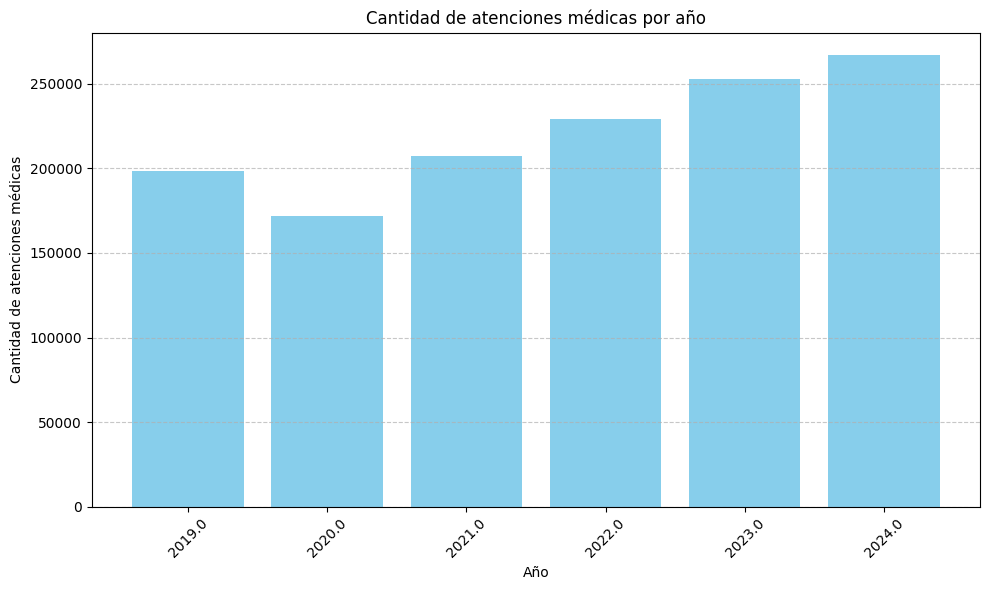

In [ ]:
cantidad_año = muestra_filtrada.groupby('AÑO')['Cantidad'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(cantidad_año['AÑO'], cantidad_año['Cantidad'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Cantidad de atenciones médicas')
plt.title('Cantidad de atenciones médicas por año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
muestra_filtrada['Nombre_Tipo_Atencion_Arp'].unique()

<ArrowStringArray>
[                  'AMBULATORIA', 'UNIDAD DE CUIDADOS INTENSIVOS',
       'QUIRURGICO HOSPITALARIO',        'QUIRURGICO AMBULATORIO',
                  'HOSPITALARIA',                'ALTA INMEDIATA',
                   'ODONTOLOGIA']
Length: 7, dtype: string

In [ ]:
# Agrupar los datos para el gráfico
df_grouped = muestra_filtrada.groupby(['AÑO', 'Nombre_Tipo_Atencion_Arp'])['Cantidad'].sum().reset_index()

# Crear gráfico de barras apiladas
fig = px.bar(
    df_grouped,
    x='AÑO',
    y='Cantidad',
    color='Nombre_Tipo_Atencion_Arp',
    title='Cantidad por Tipo de Atención y Año (Apilado)',
    labels={'Cantidad': 'Cantidad de atenciones', 'AÑO': 'Año'},
    color_discrete_sequence=px.colors.qualitative.Set3,
    height=1200
)

# Ajustes de layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Año',
    yaxis_title='Cantidad de atenciones',
    legend_title='Tipo de atención',
    bargap=0.15
)

fig.show()

Cantidad por periodo

In [6]:
muestra_filtrada['PERIODO'] = muestra_filtrada['PERIODO'].astype(str)

# Extraer año y mes
muestra_filtrada['AÑO_PER'] = muestra_filtrada['PERIODO'].str.slice(0, 4)
muestra_filtrada['MES'] = muestra_filtrada['PERIODO'].str.slice(5, 7)

# Agrupar por año y mes, sumando la cantidad
df_line = muestra_filtrada.groupby(['AÑO_PER', 'MES'])['Cantidad'].sum().reset_index()

# Ordenar los meses correctamente
df_line['MES'] = df_line['MES'].astype(int)
df_line = df_line.sort_values(by='MES')

<ipython-input-6-479444f2c949>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['PERIODO'] = muestra_filtrada['PERIODO'].astype(str)
<ipython-input-6-479444f2c949>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['AÑO_PER'] = muestra_filtrada['PERIODO'].str.slice(0, 4)
<ipython-input-6-479444f2c949>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
# Convertir a string para el eje X
df_line['MES'] = df_line['MES'].astype(str).str.zfill(2)

# Gráfico de líneas
fig = px.line(
    df_line,
    x='MES',
    y='Cantidad',
    color='AÑO_PER',
    markers=True,
    title='Cantidad de casos brutos mensual por Año',
    labels={'MES': 'Mes', 'Cantidad': 'Cantidad de atenciones', 'AÑO_PER': 'Año'},
    line_shape='spline'
)

fig.update_layout(
    xaxis_title='Mes',
    yaxis_title='Cantidad de atenciones',
    legend_title='Año',
    height=600
)

fig.show()


Cantidad logaritmica

In [7]:
muestra_filtrada['PERIODO'] = muestra_filtrada['PERIODO'].astype(str)

# Extraer año y mes
muestra_filtrada['AÑO_PER'] = muestra_filtrada['PERIODO'].str.slice(0, 4)
muestra_filtrada['MES'] = muestra_filtrada['PERIODO'].str.slice(5, 7)

# Agrupar por año y mes, sumando la cantidad
df_line = muestra_filtrada.groupby(['AÑO_PER', 'MES'])['Cantidad'].sum().reset_index()

# Ordenar los meses correctamente
df_line['MES'] = df_line['MES'].astype(int)
df_line = df_line.sort_values(by='MES')

# Convertir a string para el eje X
df_line['MES'] = df_line['MES'].astype(str).str.zfill(2)

# Crear una nueva columna para el logaritmo natural de la cantidad
df_line['log_Cantidad'] = np.log(df_line['Cantidad'])

<ipython-input-7-17dc789eb6e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['PERIODO'] = muestra_filtrada['PERIODO'].astype(str)
<ipython-input-7-17dc789eb6e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['AÑO_PER'] = muestra_filtrada['PERIODO'].str.slice(0, 4)
<ipython-input-7-17dc789eb6e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
# Gráfico con logaritmo natural de la cantidad
fig_log = px.line(
    df_line,
    x='MES',
    y='log_Cantidad',
    color='AÑO_PER',
    markers=True,
    title='Logaritmo natural de casos mensuales por Año',
    labels={'MES': 'Mes', 'log_Cantidad': 'Log(Cantidad de atenciones)', 'AÑO_PER': 'Año'},
    line_shape='spline'
)

fig_log.update_layout(
    xaxis_title='Mes',
    yaxis_title='Log(Cantidad de atenciones)',
    legend_title='Año',
    height=600
)

fig_log.show()


#### Observar las categorías laborales o no laborales

In [8]:
mapeo_categorias = {
    "ANTICIPOS  TRASALDO TAXI INTERMUNICIPAL": "2 ANTICIPOS TRASALDO TAXI INTERMUNICIPAL",
    "AYUDAS  DIAGNOSTICAS AUDITIVAS SEG 4(L)": "1 AYUDAS DIAGNOSTICAS AUDITIVAS SEG 4",
    "SEGUIMIENT REHABILIT INTEGRAL AUX ENFE(L)": "1 SEGUIMIENTO REHABILITACION INTEGRAL AUX ENFER",
    "GESTION REHABILITAC INTEGRAL AUX ENFER(L)": "1 GESTION REHABILITACION INTEGRAL AUX ENFER",
    "SEGUIMIENTO GIPAC (ALTA COMPLEJIDAD) (L)": "1 SEGUIMIENTO GIPAC (ALTA COMPLEJIDAD)",
    "GESTIÓN PRIORIDADES AUXILIAR ENFERMER (L)": "1 GESTION PRIORIDADES AUXILIAR ENFERMER",
    "GESTIÓN PRIORIDADES ENFERMERA JEFE (L)": "1 GESTION PRIORIDADES ENFERMERA JEFE",
    "SEGUIMIENTO RIESGO GESEC (EGRESOS) (L)": "1 SEGUIMIENTO RIESGO GESEC (EGRESOS)",
    "SEGUIMIENTO QA (L)": "1 SEGUIMIENTO QA",
    "SEGUIMIENTO TRÁNSITO (L)": "1 SEGUIMIENTO TRANSITO",
    "GESTIÓN GIPAC (ALTA COMPLEJIDAD) (L)": "1 GESTION GIPAC (ALTA COMPLEJIDAD)",
    "GESTIÓN RIESGO GESEC (EGRESOS) (L)": "1 GESTION RIESGO GESEC (EGRESOS)",
    "GESTIÓN QA (L)": "1 GESTION QA",
    "GESTIÓN TRÁNSITO (L)": "1 GESTION TRANSITO",
    "PREPARADO MAGISTRAL (L)": "1 PREPARADO MAGISTRAL",
    "TRANSPORTE DE MUESTRA COVID (L)": "1 TRANSPORTE DE MUESTRA COVID",
    "ASESORÍA TOXICOLOGÍA ( L)": "1 ASESORIA TOXICOLOGIA",
    "TELECONSULTA CIRUGIA PLASTICA": "2 TELECONSULTA CIRUGIA PLASTICA",
    "TELECONSULTA PRIORITARIA": "2 TELECONSULTA PRIORITARIA",
    "TELECONSULTA PSIQUIATRIA": "2 TELECONSULTA PSIQUIATRIA",
    "TELECONSULTA MED DOLOR": "2 TELECONSULTA MED DOLOR",
    "TELECONSULTA ORTOPEDIA": "2 TELECONSULTA ORTOPEDIA",
    "TELECONSULTA FISIATRIA": "2 TELECONSULTA FISIATRIA",
    "PROTESIS DIGITAL (L)": "1 PROTESIS DIGITAL",
    "CONSULTA ODONTOLOGICA TELEMEDICINA(L)": "1 CONSULTA ODONTOLOGICA TELEMEDICINA",
    "INSUMOS NUTRICIONALES (L)": "1 INSUMOS NUTRICIONALES",
    "TELEIMÁGENES RX PANORAMICOS ODONTOLOG (L": "1 TELEIMAGENES RX PANORAMICOS ODONTOLOGIA",
    "CONSULTA NEUROCIRUGIA TELEEXPERTICIA(L)": "1 CONSULTA NEUROCIRUGIA TELEEXPERTICIA",
    "CONSULTA PSIQUIATRIA TELEEXPERTICIA (L)": "1 CONSULTA PSIQUIATRIA TELEEXPERTICIA",
    "INTERCONSULTOR JNC": "2 INTERCONSULTOR JNC",
    "INTERCONSULTOR JRC": "2 INTERCONSULTOR JRC",
    "PSICOTERAPIA DE GRUPO POR PSICOLOGIA (L)": "1 PSICOTERAPIA DE GRUPO POR PSICOLOGIA",
    "INYE_ MATERIAL MIORELAJAN (TOXI-BOTUL) L": "1 INYECCION MATERIAL MIORELAJANTE (TOXI-BOTUL)",
    "IMPLANTOLOGIA(L)": "1 IMPLANTOLOGIA",
    "GASTOS TRASLADO  CITA  JUNTA NACIONAL (L": "1 GASTOS TRASLADO CITA JUNTA NACIONAL",
    "GASTOS TRASLADO  CITA  JUNTA REGIONAL (L": "1 GASTOS TRASLADO CITA JUNTA REGIONAL",
    "GASTOS TRASLADO PARA CALIFICACIÓN PCL (L": "1 GASTOS TRASLADO PARA CALIFICACION PCL",
    "GASTOS DE TRASLADO ASISTENCIAL CITAS (L)": "1 GASTOS DE TRASLADO ASISTENCIAL CITAS",
    "CONSULTA ESPECIALI EXTRAMURAL ORTOPEDIA": "2 CONSULTA ESPECIALIDAD EXTRAMURAL ORTOPEDIA",
    "CONSULTA ESPECIALI EXTRAMURAL FISIATRIA": "2 CONSULTA ESPECIALIDAD EXTRAMURAL FISIATRIA",
    "ANTICIPO TRASLADO EN BUS INTERMUNICIPAL": "2 ANTICIPO TRASLADO EN BUS INTERMUNICIPAL",
    "ANTICIPOSš TRASALDO TAXI INTERMUNICIPAL": "2 ANTICIPOS TRASALDO TAXI INTERMUNICIPAL",
    "PROGRAMAR CIRUGIAS O PROCEDIMIENTOS (LOG": "2 PROGRAMAR CIRUGIAS O PROCEDIMIENTOS",
    "TRANSPORTE AMBULANCIA FLUVIAL (L)": "1 TRANSPORTE AMBULANCIA FLUVIAL",
    "KIT PAÑALES, INSUMOS PARA CUIDAD EN CAMA": "2 KIT PAÑALES, INSUMOS PARA CUIDADO EN CAMA",
    "AUTOATENCIÓN (L)": "1 AUTOATENCION",
    "NOTIFICACIÓN ANTE-JUNTAS(L)": "1 NOTIFICACION ANTE-JUNTAS",
    "ASESORIA JURIDICA": "2 ASESORIA JURIDICA",
    "SILLAS RUEDAS, PROTESIS PTE DE (LOGIS) L": "1 SILLAS RUEDAS, PROTESIS PTE DE (LOGIS)",
    "INSUMOS ESPECIALES PARA QUEMADOS (L)": "1 INSUMOS ESPECIALES PARA QUEMADOS",
    "JUNTA CONCEPTO TÉCNICO ECMO ( L)": "1 JUNTA CONCEPTO TECNICO ECMO",
    "CONSULTA CIRUGIA TORAX TELEMEDICINA (L)": "1 CONSULTA CIRUGIA TORAX TELEMEDICINA",
    "CONSULTA MEDICINA INTERN DOMICILI (L)": "1 CONSULTA MEDICINA INTERNA DOMICILIARIA",
    "MANTENIMIENT-REPARACIÓN SILLAS Y CAMAS(L": "1 MANTENIMIENTO-REPARACION SILLAS Y CAMAS",
    "TOMA DE MUESTRA DRIVE TRUE (L)": "1 TOMA DE MUESTRA DRIVE TRUE",
    "TELEIMÁGENES TAC  SUPRESION DESTELLOS (L": "1 TELEIMAGENES TAC SUPRESION DESTELLOS",
    "RESCATE HELICORPORTADO(L)": "1 RESCATE HELICOPORTADO",
    "CIERRE DE CASO POR TELEMEDICINA ( L )": "1 CIERRE DE CASO POR TELEMEDICINA",
    "TOMA DE MUESTRA DOMICILIARIA (L)": "1 TOMA DE MUESTRA DOMICILIARIA",
    "ZONA DE OBSERVACION EXTENDIDA (L)": "1 ZONA DE OBSERVACION EXTENDIDA",
    "ATENCION VIRTUAL COVID_19": "2 ATENCION VIRTUAL COVID_19",
    "CALIFICACION DE ORIGEN EL TELEMEDICIN(L)": "1 CALIFICACION DE ORIGEN EL TELEMEDICINA",
    "CONSULTA CIR PLASTICA TELEEXPERTICIA(L)": "1 CONSULTA CIRUGIA PLASTICA TELEEXPERTICIA",
    "CONCEPTO  POR FAMILIARISTA (L)": "1 CONCEPTO POR FAMILIARISTA",
    "INJERTOS HUMANOS, DE OTRA ESPECIE Y SINT": "2 INJERTOS HUMANOS, DE OTRA ESPECIE Y SINTETICOS",
    "MEDICAMENTOS RIESGO BIOLOGICO DOMICIL(L)": "1 MEDICAMENTOS RIESGO BIOLOGICO DOMICILIARIO",
    "AUXILIAR DE ENFERMERIA": "2 AUXILIAR DE ENFERMERIA",
    "PROCESAMIENTO PCR COVID (L)": "1 PROCESAMIENTO PCR COVID",
    "TERAPIA DE AUDIOLOGIA TELEMEDICINA (L)": "1 TERAPIA DE AUDIOLOGIA TELEMEDICINA",
    "TERAPIA DE FONOAUDIOLOGIA TELEMEDIC (L)": "1 TERAPIA DE FONOAUDIOLOGIA TELEMEDICINA",
    "INSUMOS Y/O AYUDAS BAJA VISION CEGUER (L": "1 INSUMOS Y/O AYUDAS BAJA VISION CEGUERA",
    "NEUROESTIMULADOR": "2 NEUROESTIMULADOR",
    "CONSULTA MÉDICO LABORAL TELEMEDICINA (L)": "1 CONSULTA MEDICO LABORAL TELEMEDICINA",
    "CAMA DE ACOMPAÑANTE CON ALIMENTACIÓN": "2 CAMA DE ACOMPAÑANTE CON ALIMENTACION",
    "INSUMOS DE CUIDADO EN CASA (L)": "1 INSUMOS DE CUIDADO EN CASA",
    "SEG  ADAPTACIÓN RECONVERSION MANO OBRA(L": "1 SEGUIMIENTO ADAPTACION RECONVERSION MANO OBRA",
    "VAL INTERDISCIP REHABILIT REC MANO OBRA(L)": "1 VALORACION INTERDISCIPLINARIA REHABILITACION RECONVERSION MANO OBRA",
    "SEGUIMI  INCLUS SOCIOLAB LINEA ESTAB(L)": "1 SEGUIMIENTO INCLUSION SOCIOLABORAL LINEA ESTABILIZACION",
    "VAL INTERDISCIPLIN INCLUSIÓN SOCIOLAB(L)": "1 VALORACION INTERDISCIPLINARIA INCLUSION SOCIOLABORAL",
    "VAL POR FISIATRÍA INCUMPLIM OBJETIV(L)": "1 VALORACION POR FISIATRIA INCUMPLIMIENTO OBJETIVOS",
    "INICIO PLAN DE REHABILITACIÓN (L)": "1 INICIO PLAN DE REHABILITACION",
    "SEGUIMIENTO RIESGO BIOLÓGICO AUX ENF": "2 SEGUIMIENTO RIESGO BIOLOGICO AUX ENFER",
    "GESTION RIESGO BIOLÓGICO AUX ENFERM": "2 GESTION RIESGO BIOLOGICO AUX ENFERM",
    "INGRESO Y/O ENTREGA CASOS EL DE EMPRESA": "2 INGRESO Y/O ENTREGA CASOS EL DE EMPRESA",
    "AUD. MEDICA PROCESO RECOBRO DE EPS A ARL": "2 AUDITORIA MEDICA PROCESO RECOBRO DE EPS A ARL",
    "CONTROVERSIA JRCI PCL": "2 CONTROVERSIA JRCI PCL",
    "CONTROVERSIA JRCI AT EL": "2 CONTROVERSIA JRCI AT EL",
    "APERTURA CASOS NO AVISADOS": "2 APERTURA CASOS NO AVISADOS",
    "APELACIÓN JUNTA NACIONAL PCL": "2 APELACION JUNTA NACIONAL PCL",
    "APELACIÓN JUNTA NACIONAL ORIGEN AT EL": "2 APELACION JUNTA NACIONAL ORIGEN AT EL",
    "REHABILITACION POSTCOVID NIVEL 3 (L)": "1 REHABILITACION POSTCOVID NIVEL 3",
    "REHABILITACION POSTCOVID NIVEL 2 (L)": "1 REHABILITACION POSTCOVID NIVEL 2",
    "REHABILITACION POST COVID NIVEL 1 (L)": "1 REHABILITACION POST COVID NIVEL 1",
    "INTERVENCION INTERDISP. ADAPTACION LABOR": "2 INTERVENCION INTERDISCIPLINARIA ADAPTACION LABORAL",
    "SGTO  MEDICO RIESGO BIOLOGICO (ADMONCAS)": "2 SEGUIMIENTO MEDICO RIESGO BIOLOGICO (ADMINISTRACION CASOS)",
    "UCRI": "2 UCRI",
    "UNID CUIDADOS RESPIRAT INTERMED (L)": "1 UNIDAD CUIDADOS RESPIRATORIOS INTERMEDIOS",
    "ATENCION MEDICA EN SU EMPRESA ( L)": "1 ATENCION MEDICA EN SU EMPRESA",
    "PROGRAMA DE ANTICOAGULACIÓN POP (L)": "1 PROGRAMA DE ANTICOAGULACION POP",
    "OXIGENO COVID EN TELEMONITOREO (L)": "1 OXIGENO COVID EN TELEMONITOREO",
    "OXIGENO DOMICILIARIO": "2 OXIGENO DOMICILIARIO",
    "STAFF DE OTORRINOLARINGOLOGÍA (L)": "1 STAFF DE OTORRINOLARINGOLOGIA",
    "CONSULTA TOXICOLOGIA TELEMEDICINA (L)": "1 CONSULTA TOXICOLOGIA TELEMEDICINA",
    "CONSULTA GASTROENTEROLOGIA TELEMEDIC (L)": "1 CONSULTA GASTROENTEROLOGIA TELEMEDICINA",
    "TRABAJO SOCIAL DOMICILIARIO (L)": "1 TRABAJO SOCIAL DOMICILIARIO",
    "HOTELERIA": "2 HOTELERIA",
    "CONSULTA FISIATRIA TELEEXPERTICIA (L)": "1 CONSULTA FISIATRIA TELEEXPERTICIA",
    "CONSULTA VIRTUAL NO PROGRAMADA MSI (L)": "1 CONSULTA VIRTUAL NO PROGRAMADA MSI",
    "CONSULTA NO PROGRA RIESGO BIOLÓGICO": "2 CONSULTA NO PROGRAMADA RIESGO BIOLOGICO",
    "GESTION SEVERO MSI (L)": "1 GESTION SEVERO MSI",
    "CONSULTA PREFERENTE TELEMEDICINA (L)": "1 CONSULTA PREFERENTE TELEMEDICINA",
    "CALIFICACION PCL TELEMEDICINA (L)": "1 CALIFICACION PCL TELEMEDICINA",
    "CONSULTA MD DOLOR TELEEXPERTICIA (L)": "1 CONSULTA MEDICINA DOLOR TELEEXPERTICIA",
    "CONSULTA ORTOPEDIA TELEEXPERTICIA(L)": "1 CONSULTA ORTOPEDIA TELEEXPERTICIA",
    "CONSULTACIRUGIA GENERAL TELEMEDICINA (L)": "1 CONSULTA CIRUGIA GENERAL TELEMEDICINA",
    "ASESORIA OFTALMOLOGIA (L)": "1 ASESORIA OFTALMOLOGIA",
    "CONSULTA OPTOMETRIA TELEMEDICINA(L)": "1 CONSULTA OPTOMETRIA TELEMEDICINA",
    "CONSULTA PREFERENTE CIRUGIA PLASTICA (L)": "1 CONSULTA PREFERENTE CIRUGIA PLASTICA",
    "CONSULTA DE NEUROPSICOLOGIA TELEMED (L)": "1 CONSULTA DE NEUROPSICOLOGIA TELEMEDICINA",
    "TERAPIA DE NEUROPSICOLOGIA TELEMEDIC (L)": "1 TERAPIA DE NEUROPSICOLOGIA TELEMEDICINA",
    "TELEORIENTACION EN REHABILITACION": "2 TELEORIENTACION EN REHABILITACION",
    "REHABILITACION DEPORTIVA (L)": "1 REHABILITACION DEPORTIVA",
    "RX PERIAPICAL OCLUSAL Y CORONAL  (L)": "1 RX PERIAPICAL OCLUSAL Y CORONAL",
    "CONSULTA FALLIDA": "2 CONSULTA FALLIDA",
    "CONSULTA REUMATOLOGIA TELEMEDICINA  (L)": "1 CONSULTA REUMATOLOGIA TELEMEDICINA",
    "CONSULTA UROLOGIA TELEMEDICINA (L)": "1 CONSULTA UROLOGIA TELEMEDICINA",
    "PROCESAM PRUEBA DETECCIÓN ANTIGENO COVID": "2 PROCESAMIENTO PRUEBA DETECCION ANTIGENO COVID",
    "TOMA PRUEBA DETECCIÓN ANTIGENO COVID DOM": "2 TOMA PRUEBA DETECCION ANTIGENO COVID DOMICILIARIA",
    "CIRUGIA DE CORNEA (L)": "1 CIRUGIA DE CORNEA",
    "SALUD EN LA COMUNIDAD DOMICILIARIA": "2 SALUD EN LA COMUNIDAD DOMICILIARIA",
    "PERIODONCIA(L)": "1 PERIODONCIA",
    "ENDONDOCIA(L)": "1 ENDODONCIA",
    "CONSULTA PRIORITARIA ODONTOLOGIA (L)": "1 CONSULTA PRIORITARIA ODONTOLOGIA",
    "CONSULTA DE AUDIOLOGIA": "2 CONSULTA DE AUDIOLOGIA",
    "ECMO TRANSPORTE (L)": "1 ECMO TRANSPORTE",
    "CONSULTA PREFERENTE DE PSIQUIATRIA(L)": "1 CONSULTA PREFERENTE DE PSIQUIATRIA",
    "CONSULTA PREFERENTE RIESGO BIOLÓGICO ( L": "1 CONSULTA PREFERENTE RIESGO BIOLOGICO",
    "RNM A CAMPO ABIERTO (L)": "1 RNM A CAMPO ABIERTO",
    "TELEIMÁGENES RX ODONTOLÓGICOS (L)": "1 TELEIMAGENES RX ODONTOLOGICOS",
    "ATENCION(VISITA)DOMICILIARIA MD GENER(L)": "1 ATENCION (VISITA) DOMICILIARIA MEDICO GENERAL",
    "TRANSPORTE MEDICAMENTOS AFI": "2 TRANSPORTE MEDICAMENTOS AFI",
    "ENFERMERA DE GESTION": "2 ENFERMERA DE GESTION",
    "TIQUETES  AEREOS  COMERCIAL": "2 TIQUETES AEREOS COMERCIAL",
    "COSTAS Y AGENCIAS": "2 COSTAS Y AGENCIAS",
    "GASTOS DEL PROCESO": "2 GASTOS DEL PROCESO",
    "HONORARIOS JURIDICO": "2 HONORARIOS JURIDICO",
    "REEMBOLSO POR TRANSPORTE P N BUS": "2 REEMBOLSO POR TRANSPORTE P N BUS",
    "REEMBOLSO POR TRANSPORTE P N AVION": "2 REEMBOLSO POR TRANSPORTE P N AVION",
    "PAGOS A JUNTAS": "2 PAGOS A JUNTAS",
    "INVESTIGACIONES Y VISITAS PENSIONADOS": "2 INVESTIGACIONES Y VISITAS PENSIONADOS",
    "PUBLICACIONES EN PRENSA": "2 PUBLICACIONES EN PRENSA",
    "MEDICAMENTOS SALUD EN CASA": "2 MEDICAMENTOS SALUD EN CASA",
    "GASTOS DE VIAJE PACIENTE": "2 GASTOS DE VIAJE PACIENTE",
    "REEMBOLSO POR ALOJAMIENTO Y ALIMENTACION": "2 REEMBOLSO POR ALOJAMIENTO Y ALIMENTACION",
    "REEMBOLSO POR TRANSPORTE P N TAXI": "2 REEMBOLSO POR TRANSPORTE P N TAXI",
    "CALIFICACION DE ORIGEN EL": "2 CALIFICACION DE ORIGEN EL",
    "CALIFICACIO PERDIDA DE CAPACIDAD LABORAL": "2 CALIFICACION PERDIDA DE CAPACIDAD LABORAL",
    "CALIFICACIÓN DE ORIGEN AT": "2 CALIFICACION DE ORIGEN AT",
    "VIATICOS A PACIENTES JUNTA": "2 VIATICOS A PACIENTES JUNTA",
    "VALORACION EQUIPO INTERCONSULTOR": "2 VALORACION EQUIPO INTERCONSULTOR",
    "LINEA SOPORTE ESPECIALES": "2 LINEA SOPORTE ESPECIALES",
    "ANTICIPOS  TRASALDO TAXI URBANO E INTERM": "2 ANTICIPOS TRASALDO TAXI URBANO E INTERMUNICIPAL",
    "ANTICIPO ALIMENTACION": "2 ANTICIPO ALIMENTACION",
    "ANTICIPO TRASLADO EN BUS URBANO E INTERM": "2 ANTICIPO TRASLADO EN BUS URBANO E INTERMUNICIPAL",
    "RESPONSABILIDAD CIVIL": "2 RESPONSABILIDAD CIVIL",
    "AUDITORIA MEDICA CONCURRENTE": "2 AUDITORIA MEDICA CONCURRENTE",
    "RX PANORAMICOS - ODONTOLOGIA (L)": "1 RX PANORAMICOS - ODONTOLOGIA",
    "TAC DE CONO -ODONTOLOGIA (L)": "1 TAC DE CONO -ODONTOLOGIA",
    "RESPUESTA RAPID MD DOMIC COVID 24 HOR(L)": "1 RESPUESTA RAPIDA MEDICO DOMICILIARIO COVID 24 HORAS",
    "MANEJO DOMIC PTE COVID CON OXIG-PRESEN(L": "1 MANEJO DOMICILIARIO PACIENTE COVID CON OXIGENO-PRESENCIAL",
    "MED DOMIC COVID MODELO TELEMONITOREO (L)": "1 MEDICO DOMICILIARIO COVID MODELO TELEMONITOREO",
    "INGRESO Y MONITOREO PACIENTE COVID (L)": "1 INGRESO Y MONITOREO PACIENTE COVID",
    "TELEIMÁGENES DE GAMAGRAFÍA(L)": "1 TELEIMAGENES DE GAMAGRAFIA",
    "TELEIMÁGENES RNM RESONANCIA NUCLEARM (L)": "1 TELEIMAGENES RNM RESONANCIA NUCLEAR MAGNETICA",
    "CONTINUIDAD TTO HOSPITALARIO (L)": "1 CONTINUIDAD TRATAMIENTO HOSPITALARIO",
    "TERAPIA DE PSICOLOGIA TELEMEDICINA (L)": "1 TERAPIA DE PSICOLOGIA TELEMEDICINA",
    " INYE O INFUSION SUST TERAPEUTICA/PR (L)": "1 INYECCION O INFUSION SUSTANCIA TERAPEUTICA/PR",
    "FLUOROSCOPIA (L)": "1 FLUOROSCOPIA",
    "CONSULTA MÉDICO GENERAL TELEXPERTICIA (L": "1 CONSULTA MEDICO GENERAL TELEXPERTICIA",
    "TERAPIA ECMO (L)": "1 TERAPIA ECMO",
    "LABORATORIOS DOMICILIARIO (L)": "1 LABORATORIOS DOMICILIARIO",
    "ANTICIPO HOSPEDAJE": "2 ANTICIPO HOSPEDAJE",
    "MSI -MEDICO SEGUIMIENTO INTEGRAL": "2 MSI -MEDICO SEGUIMIENTO INTEGRAL",
    "INVESTIGACION DE ACCIDENTE DE TRABAJO": "2 INVESTIGACION DE ACCIDENTE DE TRABAJO",
    "CONSULTA NUTRICION TELEMEDICINA (L)": "1 CONSULTA NUTRICION TELEMEDICINA",
    "CONSULTA MSI TELEMEDICINA (L)": "1 CONSULTA MSI TELEMEDICINA",
    "TELECONSULTA NEUROCIRUGIA": "2 TELECONSULTA NEUROCIRUGIA",
    "CONSULTA URGENCIA POR TELEMEDICINA (L)": "1 CONSULTA URGENCIA POR TELEMEDICINA",
    "URGENCIAS DE QUEMADOS (L)": "1 URGENCIAS DE QUEMADOS",
    "CONSULTA PREFERENTE NEUROCIRUGIA (L)": "1 CONSULTA PREFERENTE NEUROCIRUGIA",
    "TERAPIA PARA TINNITUS ( L)": "1 TERAPIA PARA TINNITUS",
    "AUDIFONOS Y SUMINISTROS": "2 AUDIFONOS Y SUMINISTROS",
    "CONSULTA EXTERNA PREFERENTE": "2 CONSULTA EXTERNA PREFERENTE",
    "RX ODONTOLÓGICOS (L)": "1 RX ODONTOLOGICOS",
    "CONSULTA PREFERENTE EN EMPRESA": "2 CONSULTA PREFERENTE EN EMPRESA",
    "MANEJO DOMICIL DE PTE FALLECIDO COVID(L)": "1 MANEJO DOMICILIARIO DE PACIENTE FALLECIDO COVID",
    "FOTOTERAPIA (L)": "1 FOTOTERAPIA",
    "REHABILITACION POSTCOVID": "2 REHABILITACION POSTCOVID",
    "REHABILITACION POSTCOVID CARDIOPULMON (L": "1 REHABILITACION POSTCOVID CARDIOPULMONAR",
    "URGENCIAS ODONTOLOGIA (L)": "1 URGENCIAS ODONTOLOGIA",
    "ASISTENCIA EN EL EXTERIOR": "2 ASISTENCIA EN EL EXTERIOR",
    "UNIDAD DE QUEMADOS": "2 UNIDAD DE QUEMADOS",
    "TELEIMÁGENES IMAGENOLOGIA ESPECIAL(L)": "1 TELEIMAGENES IMAGENOLOGIA ESPECIAL",
    "CONSULTA Y/O SERVICIO NUTRICION DOMIC (L": "1 CONSULTA Y/O SERVICIO NUTRICION DOMICILIARIA",
    "VACUNACION HEPATITIS C (L)": "1 VACUNACION HEPATITIS C",
    "VACUNACION HEPATITIS B (L)": "1 VACUNACION HEPATITIS B",
    "TELEORIENTACIÓN EN PSICOLOGÍA": "2 TELEORIENTACION EN PSICOLOGIA",
    "CONSULTA DE PSICOLOGIA POR TELEMEDIC (L)": "1 CONSULTA DE PSICOLOGIA POR TELEMEDICINA",
    "PSICOLOGIA DOMICILIARIA (L)": "1 PSICOLOGIA DOMICILIARIA",
    "TELEIMÁGENES TAC - TOMOGRAFIA (L)": "1 TELEIMAGENES TAC - TOMOGRAFIA",
    "TELEIMÁGENES RADIOGRAFIA(L)": "1 TELEIMAGENES RADIOGRAFIA",
    "TELEIMAGENES ECOGRAFIA ULTRASONOGRAFIA(L": "1 TELEIMAGENES ECOGRAFIA ULTRASONOGRAFIA",
    "VACUNA ANTI RABIA - PERRO - GATO (L)": "1 VACUNA ANTI RABIA - PERRO - GATO",
    "AYUDAS šDIAGNOSTICAS AUDITIVAS SEG 4(L)": "1 AYUDAS DIAGNOSTICAS AUDITIVAS SEG 4",
    "TOMA MUESTRA PRUEBA RÁPIDA COVID DOMICI": "2 TOMA MUESTRA PRUEBA RAPIDA COVID DOMICILIARIA",
    "CUIDADO PTE CRONICO O INTERMEDIO-DOMIC(L": "1 CUIDADO PACIENTE CRONICO O INTERMEDIO-DOMICILIARIO",
    "COMPRA DE CAMA HOSPITALARIA (L)": "1 COMPRA DE CAMA HOSPITALARIA",
    "ALQUILER DE CAMA HOSPITALARIA (L)": "1 ALQUILER DE CAMA HOSPITALARIA",
    "CONSULTA NEFROLOGIA TELEMEDICINA (L)": "1 CONSULTA NEFROLOGIA TELEMEDICINA",
    "INFECTOLOGÍA POR TELEMEDICINA (L)": "1 INFECTOLOGIA POR TELEMEDICINA",
    "ARTROSCOPIA DE TOBILLO (L)": "1 ARTROSCOPIA DE TOBILLO",
    "HOSPITALIZACION DE PSIQUIATRIA (L)": "1 HOSPITALIZACION DE PSIQUIATRIA",
    "ARTROTAC (L)": "1 ARTROTAC",
    "HOSPITAL DÍA": "2 HOSPITAL DIA",
    "ENTREGA PRÓTESIS ORTESIS A DOMICILIO (L)": "1 ENTREGA PROTESIS ORTESIS A DOMICILIO",
    "PRUEBA DE TUBERCULINA ( L)": "1 PRUEBA DE TUBERCULINA",
    "VAL INTERDISCIPL INICIAL REHAB INTEG(L)": "1 VALORACION INTERDISCIPLINARIA INICIAL REHABILITACION INTEGRAL",
    "CONSULTA INICIAL MEDICO LABORAL IPS(L)": "1 CONSULTA INICIAL MEDICO LABORAL IPS",
    "CONSULTAS Y PROC  MEDICINA ALTERNATIV(L)": "1 CONSULTAS Y PROCEDIMIENTOS MEDICINA ALTERNATIVA",
    "TERAPIA NEURAL (L)": "1 TERAPIA NEURAL",
    "ACUPUNTURA (L)": "1 ACUPUNTURA",
    "ONDAS DE CHOQUE (L)": "1 ONDAS DE CHOQUE",
    "TOMA PRUEBA DETECCIÓN ANTIGENO COVID INS": "2 TOMA PRUEBA DETECCION ANTIGENO COVID INSTITUCIONAL",
    "CONSULTA PRIORITARIA TELEMEDICINA (L)": "1 CONSULTA PRIORITARIA TELEMEDICINA",
    "TRANSPORTE DE PACIENTES (TAXI U OTROS)": "2 TRANSPORTE DE PACIENTES (TAXI U OTROS)",
    "TERAPEUTA OCUPACIONAL TELEMEDICINA (L)": "1 TERAPEUTA OCUPACIONAL TELEMEDICINA",
    "URGENCIAS ACCIDENTE OFIDICO - SERPIENT L": "1 URGENCIAS ACCIDENTE OFIDICO - SERPIENTE",
    "URODINAMIA (L)": "1 URODINAMIA",
    "ADITAMENTOS PARA BAJA VISION (L)": "1 ADITAMENTOS PARA BAJA VISION",
    "REHABILITACION DE BAJA VISION (L)": "1 REHABILITACION DE BAJA VISION",
    "PANEL VIRAL RESPIRATORIO (L)": "1 PANEL VIRAL RESPIRATORIO",
    "CONSULTA CARDIOLOGIA TELEMEDICINA (L)": "1 CONSULTA CARDIOLOGIA TELEMEDICINA",
    "REEMPLAZO ARTICULAR HOMBRO (L)": "1 REEMPLAZO ARTICULAR HOMBRO",
    "REEMPLAZO ARTICULAR CADERA (L)": "1 REEMPLAZO ARTICULAR CADERA",
    "ORTOPEDIA DE ALARGAMIENTO OSEO (L)": "1 ORTOPEDIA DE ALARGAMIENTO OSEO",
    "CIRUGÍA ORTOPEDIA DE CADERA (L)": "1 CIRUGIA ORTOPEDIA DE CADERA",
    "REEMPLAZO ARTICULAR RODILLA  (L)": "1 REEMPLAZO ARTICULAR RODILLA",
    "MICROCIRUGIA , MICROCIRUJANO (L)": "1 MICROCIRUGIA, MICROCIRUJANO",
    "CIRUGIA ORTOPEDIA DE TOBILLO Y PIE (L)": "1 CIRUGIA ORTOPEDIA DE TOBILLO Y PIE",
    "PRUEBA RÁPIDA COVID DOMICILIARIO": "2 PRUEBA RAPIDA COVID DOMICILIARIO",
    "TRANSPORTE AMBULANCIA AEREA": "2 TRANSPORTE AMBULANCIA AEREA",
    "STAFF DE MEDICINA DEL DOLOR (L)": "1 STAFF DE MEDICINA DEL DOLOR",
    "TOMA-PROCES DETECCION ANTIGENO COVID DOM": "2 TOMA-PROCESAMIENTO DETECCION ANTIGENO COVID DOMICILIARIA",
    "SERVICIOS MEDICOS Y HOSPI DOMICILIARIO": "2 SERVICIOS MEDICOS Y HOSPITALIZACION DOMICILIARIA",
    "CONSULTA PSIQUIATRIA TELEMEDICINA (L)": "1 CONSULTA PSIQUIATRIA TELEMEDICINA",
    "TERAPIA FONOAUDIOLOGICA DOMICILIARIA (L)": "1 TERAPIA FONOAUDIOLOGICA DOMICILIARIA",
    "TTERAPIA OCUPACIONAL DOMICILIARIA (L)": "1 TERAPIA OCUPACIONAL DOMICILIARIA",
    'AYUDANTIA EN CIRUGIA': '2 AYUDANTIA EN CIRUGIA',
    'SERVICIOS DE  ANESTESIOLOGO EN CIRUGIA': '2 SERVICIOS DE ANESTESIOLOGO EN CIRUGIA',
    'TAC TOMOGRAFIA SUPRESION DE DESTELLOS(L)': '1 TAC TOMOGRAFIA SUPRESION DE DESTELLOS',
    'CIRUGÍA ORTOPEDIA': '2 CIRUGÍA ORTOPEDIA',
    'ECOCARDIOGRAMA (L)': '1 ECOCARDIOGRAMA',
    'MAPA MONITOREO AMBULATO PRESION ARTE (L)': '1 MAPA MONITOREO AMBULATO PRESION ARTE',
    'HOLTER (L)': '1 HOLTER',
    'LABORATORIO CLÍNICO AMBULATORIO': '2 LABORATORIO CLÍNICO AMBULATORIO',
    'PROCEDIMIENTOS AMBULATORIOS': '2 PROCEDIMIENTOS AMBULATORIOS',
    'SESIONES DE FISIOTERAPIA': '2 SESIONES DE FISIOTERAPIA',
    'CONSULTA CIRUGI DE COLUMNA-NEUROCIRUGI L': '1 CONSULTA CIRUGI DE COLUMNA-NEUROCIRUGI',
    'LARINGOSCOPIA (L)': '1 LARINGOSCOPIA',
    'CONSULTA MEDICO ESPECIALISTA': '2 CONSULTA MEDICO ESPECIALISTA',
    'CISTOSCOPIA (L)': '1 CISTOSCOPIA',
    'CISTOGRAFIA (L)': '1 CISTOGRAFIA',
    'PRUEBA DE ESFUERZO (L)': '1 PRUEBA DE ESFUERZO',
    'ECOGRAFIA - ULTRASONOGRAFIA (L)': '1 ECOGRAFIA - ULTRASONOGRAFIA',
    'SUERO ANTIOFIDICO, SERPIENTES (L)': '1 SUERO ANTIOFIDICO, SERPIENTES',
    'CONSULTA OFTALMOLOGIA RETINA(RETINOLOG)L': '1 CONSULTA OFTALMOLOGIA RETINA(RETINOLOG)',
    'CONSULTA NEFROLOGIA, NEFROLOGO (L)': '1 CONSULTA NEFROLOGIA, NEFROLOGO',
    'CONSULTA GASTROENTEROLOGÍA (L)': '1 CONSULTA GASTROENTEROLOGÍA',
    'CONSULTA REUMATOLOGIA (L)': '1 CONSULTA REUMATOLOGIA',
    'CIRUGÍA MAXILOFACIAL': '2 CIRUGÍA MAXILOFACIAL',
    'URGENCIAS RIESGO BIOLOGICO': '2 URGENCIAS RIESGO BIOLOGICO',
    'CIRUGÍA ORTOPEDIA DE HOMBRO (L)': '1 CIRUGÍA ORTOPEDIA DE HOMBRO',
    'CONSULTA ORTOPEDIA DE HOMBRO (L)': '1 CONSULTA ORTOPEDIA DE HOMBRO',
    'CIRUGÍA ORTOPEDIA DE RODILLA (L)': '1 CIRUGÍA ORTOPEDIA DE RODILLA',
    'CONSULTA ORTOPEDIA DE RODILLA  (L)': '1 CONSULTA ORTOPEDIA DE RODILLA',
    'DIAGNOSTICO VASCULAR (L)': '1 DIAGNOSTICO VASCULAR',
    'CONSULTA TOXICOLOGÍA, TOXICOLOGO': '2 CONSULTA TOXICOLOGÍA, TOXICOLOGO',
    'ENDOSCOPIA (L)': '1 ENDOSCOPIA',
    'COLONOSCOPIA (L)': '1 COLONOSCOPIA',
    'ELECTROCARDIOGRAMA (L)': '1 ELECTROCARDIOGRAMA',
    'ELECTROENCEFALOGRAMA (L)': '1 ELECTROENCEFALOGRAMA',
    'DOPPLER (L)': '1 DOPPLER',
    'CONSULTA Y PROCEDIMIENTOS DE ARTROSC (L)': '1 CONSULTA Y PROCEDIMIENTOS DE ARTROSC',
    'TRANSPORTE AMBULANCIA BASICA': '2 TRANSPORTE AMBULANCIA BASICA',
    'CONSULTA NEUROLOGO': '2 CONSULTA NEUROLOGO',
    'CONSULTA MEDICINA INTERNA': '2 CONSULTA MEDICINA INTERNA',
    'TER. AUDIOLOG,FONOAUD, DE LENGUA Y VESTI': '2 TER. AUDIOLOG,FONOAUD, DE LENGUA Y VESTI',
    'DIALISIS PERITONEAL Y HEMODIALISIS': '2 DIALISIS PERITONEAL Y HEMODIALISIS',
    'LABORATORIO CLINICO EN HOSPITALIZACION': '2 LABORATORIO CLINICO EN HOSPITALIZACION',
    'ESPIROMETRIA Y CURVA DE FLUJO': '2 ESPIROMETRIA Y CURVA DE FLUJO',
    'CONSULTA Y PROCEDIMIENTOS DERMATOLOGIA': '2 CONSULTA Y PROCEDIMIENTOS DERMATOLOGIA',
    'CONSULTA Y PROCEDIMIENTOS NEUMOLOGIA': '2 CONSULTA Y PROCEDIMIENTOS NEUMOLOGIA',
    'PROCEDIMIENTOS Y BLOQUEOS MD DEL DOLOR': '2 PROCEDIMIENTOS Y BLOQUEOS MD DEL DOLOR',
    'RADIOGRAFIA': '2 RADIOGRAFIA',
    'CIRUGIAS OTROS MEDICOS ESPECIALISTAS': '2 CIRUGIAS OTROS MEDICOS ESPECIALISTAS',
    'GASTOS QUIRURGICOS': '2 GASTOS QUIRURGICOS',
    'UNIDAD CUIDADO INTENSIVO ADULTO U.C.I.': '2 UNIDAD CUIDADO INTENSIVO ADULTO U.C.I.',
    'HOSPITALIZACION': '2 HOSPITALIZACION',
    'AYUDAS DIAGNOSTICAS': '2 AYUDAS DIAGNOSTICAS',
    'ANALISIS DE PUESTO DE TRABAJO PSICOSOCIA': '2 ANALISIS DE PUESTO DE TRABAJO PSICOSOCIA',
    'TERAPEUTA OCUPACIONAL': '2 TERAPEUTA OCUPACIONAL',
    'INTERVENCION PSICOLOGICA ADPT. LABORAL': '2 INTERVENCION PSICOLOGICA ADPT. LABORAL',
    'CONSULTA PSICOLOGO Y TERAPIA PSICOLOGICA': '2 CONSULTA PSICOLOGO Y TERAPIA PSICOLOGICA',
    'STAFF DE FISIATRIA (L)': '1 STAFF DE FISIATRIA',
    'ATENCIÓN PSICOLOGÍA EN CRISIS (L)': '1 ATENCIÓN PSICOLOGÍA EN CRISIS',
    'ORTESIS Y LINEA BLANDA': '2 ORTESIS Y LINEA BLANDA',
    'MEDICAMENTOS RIESGO BIOLOGICO': '2 MEDICAMENTOS RIESGO BIOLOGICO',
    'INSUMOS Y DISPOSITIVOS MÉDICOS (L)': '1 INSUMOS Y DISPOSITIVOS MÉDICOS',
    'MEDICAMENTO  CONTROL ESTUPEFACIENTES (L)': '1 MEDICAMENTO CONTROL ESTUPEFACIENTES',
    'PROCEDIMIENTOS ESPECIALIZADOS AMBULATORI': '2 PROCEDIMIENTOS ESPECIALIZADOS AMBULATORI',
    'MEDICAMENTOS AMBULATORIOS': '2 MEDICAMENTOS AMBULATORIOS',
    'OTROS PROCEDIMIENTOS HOSPITALARIOS': '2 OTROS PROCEDIMIENTOS HOSPITALARIOS',
    'URGENCIAS MEDICO GENERAL': '2 URGENCIAS MEDICO GENERAL'

}


In [10]:
df['categoria_servicios'] = df['Concepto_Factura_Desc'].map(mapeo_categorias)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_collection.py:4206: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('Concepto_Factura_Desc', 'object'))

  warnings.warn(meta_warning(meta, method="map"))


In [ ]:
df['categoria_servicios'].head()

0    2 MSI -MEDICO SEGUIMIENTO INTEGRAL
1            2 SESIONES DE FISIOTERAPIA
2                                   NaN
3                                   NaN
4                         2 RADIOGRAFIA
Name: categoria_servicios, dtype: object

In [14]:
df['urgencia'] = df['categoria_servicios'].apply(
    lambda x: 1 if x in urgencias_categorias else 0
)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_collection.py:4390: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('categoria_servicios', 'int64'))

  warnings.warn(meta_warning(meta))


In [ ]:
df[['categoria_servicios', 'urgencia']].head()

categoria_servicios  urgencia
0  2 MSI -MEDICO SEGUIMIENTO INTEGRAL         0
1          2 SESIONES DE FISIOTERAPIA         0
2                                 NaN         0
3                                 NaN         0
4                       2 RADIOGRAFIA         0

In [ ]:
df['urgencia'].unique().compute()

0    0
Name: urgencia, dtype: int64

In [9]:
muestra_filtrada['categoria_servicios'] = muestra_filtrada['Concepto_Factura_Desc'].map(mapeo_categorias)

<ipython-input-9-3977ce257dd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['categoria_servicios'] = muestra_filtrada['Concepto_Factura_Desc'].map(mapeo_categorias)


In [ ]:
muestra_filtrada['categoria_servicios'].head()

146347            2 SESIONES DE FISIOTERAPIA
128711           2 MEDICAMENTOS AMBULATORIOS
136196    2 MSI -MEDICO SEGUIMIENTO INTEGRAL
137608                                   NaN
165027               2 TERAPEUTA OCUPACIONAL
Name: categoria_servicios, dtype: object

In [ ]:
muestra_filtrada['tipo_categoria'] = muestra_filtrada['categoria_servicios'].str[0]

<ipython-input-30-e683bac91917>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
muestra_filtrada[['tipo_categoria', 'categoria_servicios', 'Concepto_Factura_Desc']].head()

tipo_categoria                 categoria_servicios  \
146347              2          2 SESIONES DE FISIOTERAPIA   
128711              2         2 MEDICAMENTOS AMBULATORIOS   
136196              2  2 MSI -MEDICO SEGUIMIENTO INTEGRAL   
137608            NaN                                 NaN   
165027              2             2 TERAPEUTA OCUPACIONAL   

                   Concepto_Factura_Desc  
146347          SESIONES DE FISIOTERAPIA  
128711         MEDICAMENTOS AMBULATORIOS  
136196  MSI -MEDICO SEGUIMIENTO INTEGRAL  
137608         MATERIAL DE OSTEOSINTESIS  
165027             TERAPEUTA OCUPACIONAL

In [ ]:
display(HTML(muestra_filtrada.head(10).to_html()))

#### Análisis geográfico

Comparar la cantidad de atención por municipio de atención vs municipio de sucursal

In [ ]:
municipio_atencion = muestra_filtrada.groupby('MUNICIPIO')['Cantidad'].sum().reset_index()
municipio_sucursal = muestra_filtrada[muestra_filtrada['Nombre_Municipio_IPS'] != '?'].groupby('Nombre_Municipio_IPS')['Cantidad'].sum().reset_index()

# Ordenar los municipios por la cantidad de atención de mayor a menor
municipio_atencion_ordenado = municipio_atencion.sort_values(by='Cantidad', ascending=False)
municipio_sucursal_ordenado = municipio_sucursal.sort_values(by='Cantidad', ascending=False)


<ipython-input-34-b28a1a9e9de3>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-34-b28a1a9e9de3>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




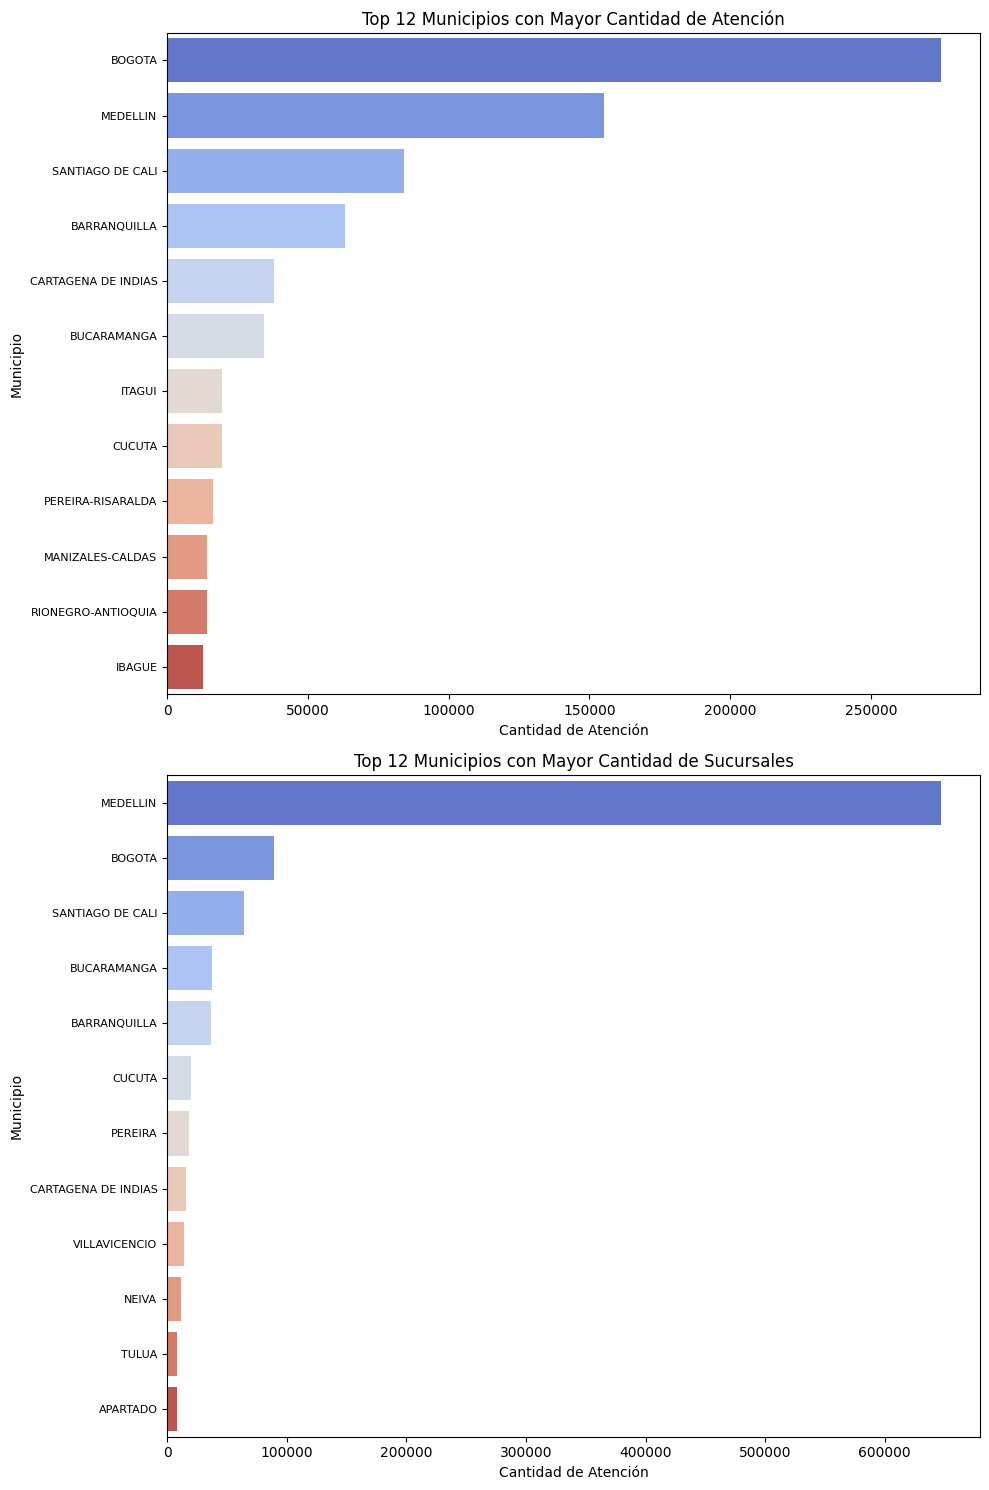

In [ ]:
top_12_municipios = municipio_atencion_ordenado.head(12)
top_12_municipios_sucursal = municipio_sucursal_ordenado.head(12)

fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Primer subgráfico: Top 12 Municipios por Cantidad de Atención
sns.barplot(x='Cantidad', y='MUNICIPIO', data=top_12_municipios, palette='coolwarm', ax=axes[0])
axes[0].set_title('Top 12 Municipios con Mayor Cantidad de Atención')
axes[0].set_xlabel('Cantidad de Atención')
axes[0].set_ylabel('Municipio')
axes[0].tick_params(axis='y', labelsize=8) # Ajustar tamaño de etiquetas si es necesario

# Segundo subgráfico: Top 12 Municipios por Cantidad de Sucursales
sns.barplot(x='Cantidad', y='Nombre_Municipio_IPS', data=top_12_municipios_sucursal, palette='coolwarm', ax=axes[1])
axes[1].set_title('Top 12 Municipios con Mayor Cantidad de Sucursales')
axes[1].set_xlabel('Cantidad de Atención')
axes[1].set_ylabel('Municipio')
axes[1].tick_params(axis='y', labelsize=8) # Ajustar tamaño de etiquetas si es necesario

plt.tight_layout()
plt.show()

In [ ]:

# Calcular la cantidad total de atención por municipio (agrupado por 'MUNICIPIO')
municipio_atencion = muestra_filtrada.groupby('MUNICIPIO')['Cantidad'].sum().reset_index()
municipio_atencion_ordenado = municipio_atencion.sort_values(by='Cantidad', ascending=False).head(12)

# Calcular la cantidad total de atención por municipio (agrupado por 'Nombre_Municipio_IPS') excluyendo '?'
municipio_ips_atencion = muestra_filtrada[muestra_filtrada['Nombre_Municipio_IPS'] != '?'].groupby('Nombre_Municipio_IPS')['Cantidad'].sum().reset_index()
municipio_ips_atencion_ordenado = municipio_ips_atencion.sort_values(by='Cantidad', ascending=False).head(12)

# Crear el primer gráfico: Top 12 Municipios por Cantidad de Atención (por 'MUNICIPIO')
fig1 = px.bar(municipio_atencion_ordenado,
              x='Cantidad',
              y='MUNICIPIO',
              orientation='h',
              title='Top 12 Municipios con Mayor Cantidad de Atención (Agrupado por MUNICIPIO)',
              labels={'Cantidad': 'Cantidad de Atención', 'MUNICIPIO': 'Municipio'},
              color='Cantidad',
              color_continuous_scale='viridis')
fig1.update_layout(yaxis={'categoryorder': 'total ascending'})
fig1.show()

# Crear el segundo gráfico: Top 12 Municipios por Cantidad de Atención (por 'Nombre_Municipio_IPS', sin '?')
fig2 = px.bar(municipio_ips_atencion_ordenado,
              x='Cantidad',
              y='Nombre_Municipio_IPS',
              orientation='h',
              title='Top 12 Municipios con Mayor Cantidad de Atención (Agrupado por Nombre_Municipio_IPS, sin "?")',
              labels={'Cantidad': 'Cantidad de Atención', 'Nombre_Municipio_IPS': 'Municipio (IPS)'},
              color='Cantidad',
              color_continuous_scale='plasma')
fig2.update_layout(yaxis={'categoryorder': 'total ascending'})
fig2.show()

Top por proporciones

In [ ]:
# Calcular la cantidad total de atención (para el primer gráfico)
total_atencion_municipio = muestra_filtrada['Cantidad'].sum()

# Calcular la cantidad de atención por municipio y su proporción
municipio_proporcion = muestra_filtrada.groupby('MUNICIPIO')['Cantidad'].sum().reset_index()
municipio_proporcion['Proporcion'] = (municipio_proporcion['Cantidad'] / total_atencion_municipio) * 100
municipio_proporcion_ordenado = municipio_proporcion.sort_values(by='Proporcion', ascending=False).head(12)

# Calcular la cantidad total de atención (para el segundo gráfico, excluyendo '?')
muestra_filtrada_sin_interrogante = muestra_filtrada[muestra_filtrada['Nombre_Municipio_IPS'] != '?']
total_atencion_ips = muestra_filtrada_sin_interrogante['Cantidad'].sum()

# Calcular la cantidad de atención por Nombre_Municipio_IPS y su proporción (sin '?')
municipio_ips_proporcion = muestra_filtrada_sin_interrogante.groupby('Nombre_Municipio_IPS')['Cantidad'].sum().reset_index()
municipio_ips_proporcion['Proporcion'] = (municipio_ips_proporcion['Cantidad'] / total_atencion_ips) * 100
municipio_ips_proporcion_ordenado = municipio_ips_proporcion.sort_values(by='Proporcion', ascending=False).head(12)

# Crear el primer gráfico: Proporción de Cantidad de Atención por Municipio
fig1 = px.bar(municipio_proporcion_ordenado,
              x='Proporcion',
              y='MUNICIPIO',
              orientation='h',
              title='Top 12 Municipios por Proporción de Cantidad de Atención',
              labels={'Proporcion': 'Proporción (%)', 'MUNICIPIO': 'Municipio'},
              color='Proporcion',
              color_continuous_scale='viridis',
              text='Proporcion') # Mostrar el valor porcentual en las barras
fig1.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig1.update_layout(yaxis={'categoryorder': 'total descending'}) # Ordenar de mayor a menor
fig1.show()

# Crear el segundo gráfico: Proporción de Cantidad de Atención por Nombre_Municipio_IPS (sin '?')
fig2 = px.bar(municipio_ips_proporcion_ordenado,
              x='Proporcion',
              y='Nombre_Municipio_IPS',
              orientation='h',
              title='Top 12 Municipios por Proporción de Cantidad de Atención (Agrupado por Nombre_Municipio_IPS, sin "?")',
              labels={'Proporcion': 'Proporción (%)', 'Nombre_Municipio_IPS': 'Municipio (IPS)'},
              color='Proporcion',
              color_continuous_scale='plasma',
              text='Proporcion') # Mostrar el valor porcentual en las barras
fig2.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig2.update_layout(yaxis={'categoryorder': 'total descending'}) # Ordenar de mayor a menor
fig2.show()

#### Visualizar top cantidad por municipio de sede de IPS a través de los años

In [ ]:
# Filtrar el DataFrame para excluir la categoría '?' en 'Nombre_Municipio_IPS'
muestra_filtrada_sin_interrogante = muestra_filtrada[muestra_filtrada['Nombre_Municipio_IPS'] != '?']

# Agrupar por año y municipio para obtener la cantidad total por año y municipio
municipio_anio_cantidad = muestra_filtrada_sin_interrogante.groupby(['AÑO', 'Nombre_Municipio_IPS'])['Cantidad'].sum().reset_index()

# Función para obtener el top N municipios para un año dado
def top_n_municipios_por_anio(df, anio, n=12):
    df_anio = df[df['AÑO'] == anio].sort_values(by='Cantidad', ascending=False).head(n)
    df_anio['Ranking'] = range(1, len(df_anio) + 1)
    return df_anio

# Crear un DataFrame con el top 12 de municipios para cada año
top_municipios_por_anio_df = pd.concat([top_n_municipios_por_anio(municipio_anio_cantidad, anio)
                                       for anio in municipio_anio_cantidad['AÑO'].unique()])

In [ ]:
# Crear el gráfico de barras animado
fig = px.bar(top_municipios_por_anio_df,
             x='Cantidad',
             y='Nombre_Municipio_IPS',
             color='Nombre_Municipio_IPS',
             animation_frame='AÑO',
             animation_group='Nombre_Municipio_IPS',
             category_orders={'Ranking': list(range(1, 13))},
             range_x=[0, top_municipios_por_anio_df['Cantidad'].max() * 1.1], # Ajustar el rango del eje x
             orientation='h',
             title='Top 12 Municipios por Cantidad de Atención a Través de los Años',
             labels={'Cantidad': 'Cantidad de Atención', 'Nombre_Municipio_IPS': 'Municipio (IPS)', 'AÑO': 'Año'},
             height=700)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500

fig.show()

#### Visualizar top cantidad por municipio de atención

In [ ]:
# Filtrar el DataFrame para excluir la categoría '?' en 'Nombre_Municipio_IPS'
muestra_filtrada_sin_interrogante2 = muestra_filtrada[muestra_filtrada['MUNICIPIO'] != '?']

# Agrupar por año y municipio para obtener la cantidad total por año y municipio
municipio_anio_cantidad2 = muestra_filtrada_sin_interrogante2.groupby(['AÑO', 'MUNICIPIO'])['Cantidad'].sum().reset_index()

# Función para obtener el top N municipios para un año dado
def top_n_municipios_por_anio(df, anio, n=12):
    df_anio = df[df['AÑO'] == anio].sort_values(by='Cantidad', ascending=False).head(n)
    df_anio['Ranking'] = range(1, len(df_anio) + 1)
    return df_anio

# Crear un DataFrame con el top 12 de municipios para cada año
top_municipios_por_anio_df2 = pd.concat([top_n_municipios_por_anio(municipio_anio_cantidad2, anio)
                                       for anio in municipio_anio_cantidad2['AÑO'].unique()])

In [ ]:
# Crear el gráfico de barras animado
fig = px.bar(top_municipios_por_anio_df2,
             x='Cantidad',
             y='MUNICIPIO',
             color='MUNICIPIO',
             animation_frame='AÑO',
             animation_group='MUNICIPIO',
             category_orders={'Ranking': list(range(1, 13))},
             range_x=[0, top_municipios_por_anio_df2['Cantidad'].max() * 1.1], # Ajustar el rango del eje x
             orientation='h',
             title='Top 12 Municipios por Cantidad de Atención a Través de los Años',
             labels={'Cantidad': 'Cantidad de Atención', 'MUNICIPIO': 'Municipio (IPS)', 'AÑO': 'Año'},
             height=700)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500

fig.show()

#### Conteo de casos laborales y casos no laborales registrados

In [ ]:
# Contar la frecuencia de cada categoría
categoria_counts = muestra_filtrada['tipo_categoria'].value_counts().reset_index()
categoria_counts.columns = ['tipo_categoria', 'count']

# Mapear los valores 1 y 2 a sus etiquetas descriptivas
categoria_counts['descripcion'] = categoria_counts['tipo_categoria'].map({'1': 'Incidentes laborales', '2': 'Incidentes no laborales'})


In [ ]:
# Crear el gráfico de pastel
fig = px.pie(categoria_counts,
             values='count',
             names='descripcion',
             title='Proporción de Incidentes Laborales vs. No Laborales',
             color='descripcion',
             color_discrete_map={'Incidentes laborales': 'skyblue',
                                 'Incidentes no laborales': 'lightcoral'},
             hover_data=['count'],
             labels={'descripcion': 'Tipo de Incidente', 'count': 'Número de Incidentes'})
fig.update_traces(textinfo='percent+label', textposition='outside')
fig.show()

#### Evolución temporal de los casos laborales vs no laborales

In [ ]:
# Mapear los valores 1 y 2 a sus etiquetas descriptivas (si aún no lo has hecho)
mapeo_tipo_categoria = {'1': 'Incidentes laborales', '2': 'Incidentes no laborales'}
muestra_filtrada['descripcion_tipo_categoria'] = muestra_filtrada['tipo_categoria'].map(mapeo_tipo_categoria)


<ipython-input-43-14dab9f3bc88>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Contar la frecuencia de cada tipo de incidente por año
conteo_tipo_anio = muestra_filtrada.groupby(['AÑO', 'descripcion_tipo_categoria']).size().reset_index(name='count')

# Crear el diagrama de barras agrupadas
fig = px.bar(conteo_tipo_anio,
             x='AÑO',
             y='count',
             color='descripcion_tipo_categoria',
             barmode='group',  # 'group' para barras agrupadas, 'stack' para barras apiladas
             title='Conteo de Incidentes Laborales vs. No Laborales por Año',
             labels={'AÑO': 'Año', 'count': 'Número de Incidentes', 'descripcion_tipo_categoria': 'Tipo de Incidente'},
             color_discrete_map={'Incidentes laborales': 'skyblue',
                                 'Incidentes no laborales': 'lightcoral'})
fig.show()

### Mapa de proporción de cantidad de atención por municipio

In [11]:
# 'MUNICIPIO2' solo el nombre del municipio en mayúsculas
def extraer_municipio(valor):
    valor = str(valor).upper()
    if '-' in valor:
        return valor.split('-')[0]  # antes del guion
    else:
        return valor  # si no hay guion, dejar igual

muestra_filtrada['MUNICIPIO2'] = muestra_filtrada['MUNICIPIO'].apply(extraer_municipio)


<ipython-input-11-6849926bb45d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['MUNICIPIO2'] = muestra_filtrada['MUNICIPIO'].apply(extraer_municipio)


In [ ]:
muestra_filtrada[['MUNICIPIO', 'MUNICIPIO2']].head(10)


MUNICIPIO        MUNICIPIO2
146347            SABANETA-ANTIOQUIA          SABANETA
128711                       SEGOVIA           SEGOVIA
136196                    VALLEDUPAR        VALLEDUPAR
137608        ZARZAL-VALLE DEL CAUCA            ZARZAL
165027                        BOGOTA            BOGOTA
31311               MANIZALES-CALDAS         MANIZALES
131739  BUENAVENTURA-VALLE DEL CAUCA      BUENAVENTURA
103256                      MEDELLIN          MEDELLIN
2700                          IBAGUE            IBAGUE
99294               SANTIAGO DE CALI  SANTIAGO DE CALI

### Correlaciones entre variables

In [ ]:
cols = ['Cantidad', 'AÑO', 'MES']
muestra_filtrada['AÑO'] = pd.to_numeric(muestra_filtrada['AÑO'], errors='coerce')
muestra_filtrada['MES'] = pd.to_numeric(muestra_filtrada['MES'], errors='coerce')

#matriz de correlación
corr = muestra_filtrada[cols].corr(method='spearman')
print("Matriz de correlación (Spearman):\n", corr)

<ipython-input-59-b6ebd8995d50>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-59-b6ebd8995d50>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Matriz de correlación (Spearman):
           Cantidad       AÑO       MES
Cantidad  1.000000 -0.011512 -0.007398
AÑO      -0.011512  1.000000 -0.012377
MES      -0.007398 -0.012377  1.000000


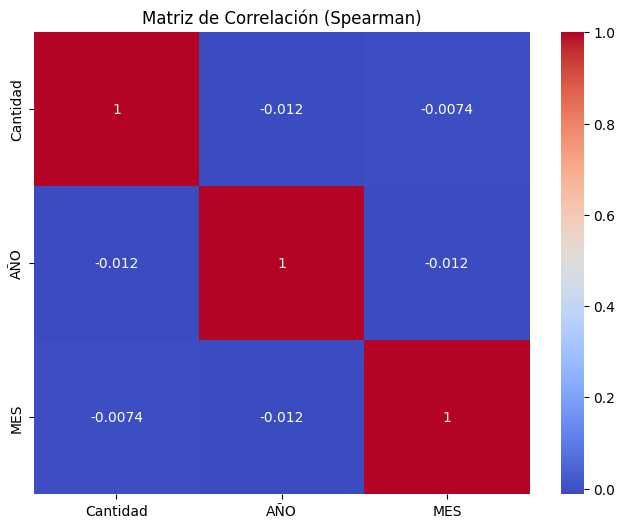

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Spearman)')
plt.show()

Correlaciones categóricas

In [ ]:
cat_vars = ['Nombre_Tipo_Atencion_Arp', 'Nombre_Municipio_IPS', 'TIPIFICACION', 'Concepto_Factura_Desc', 'MUNICIPIO', 'urgencia']



Variable categórica: Nombre_Tipo_Atencion_Arp
urgencia                            0
Nombre_Tipo_Atencion_Arp             
ALTA INMEDIATA                  37740
AMBULATORIA                    530160
HOSPITALARIA                    20409
ODONTOLOGIA                      3152
QUIRURGICO AMBULATORIO         224941
QUIRURGICO HOSPITALARIO        145137
UNIDAD DE CUIDADOS INTENSIVOS   38461
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


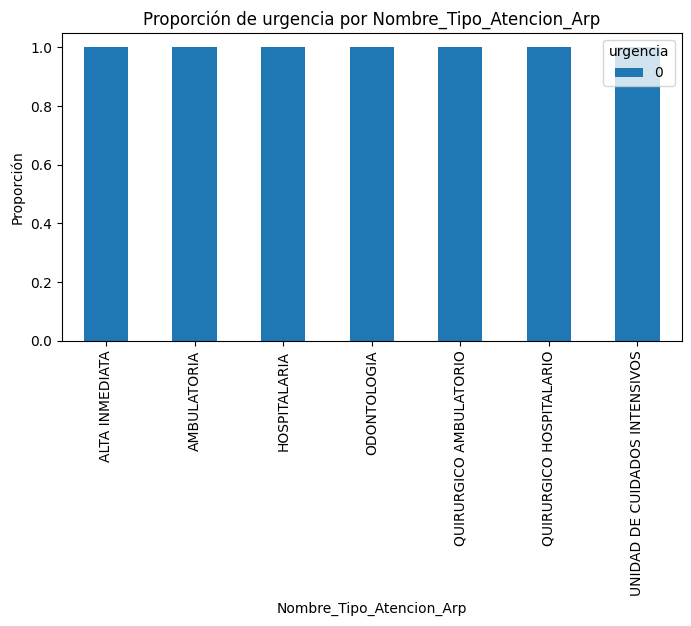


Variable categórica: Nombre_Municipio_IPS
urgencia                   0
Nombre_Municipio_IPS        
?                     153670
ABEJORRAL                 67
ABREGO                     1
ACACIAS                  168
AGUA DE DIOS              22
...                      ...
YOPAL                   1883
YOTOCO                    34
YUMBO                    224
ZARZAL                   291
ZIPAQUIRA                946

[372 rows x 1 columns]
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


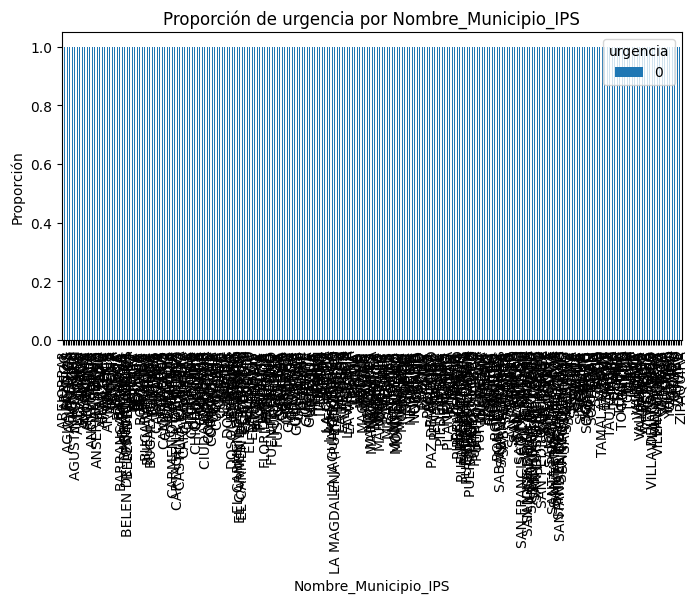


Variable categórica: TIPIFICACION
urgencia                                 0
TIPIFICACION                              
ANALISTA MOS                           325
AUTOMÁTICA IVR                       48022
AUTOMÁTICA PÁGINA WEB                73170
CITAS BACK                           92803
CITAS FRONT                         181738
OFICINAS                             16431
PLATAFORMA O PUNTO DE SERVICIO IPS  132519
URGENCIAS BACK                      141111
URGENCIAS FRONT                     313881
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


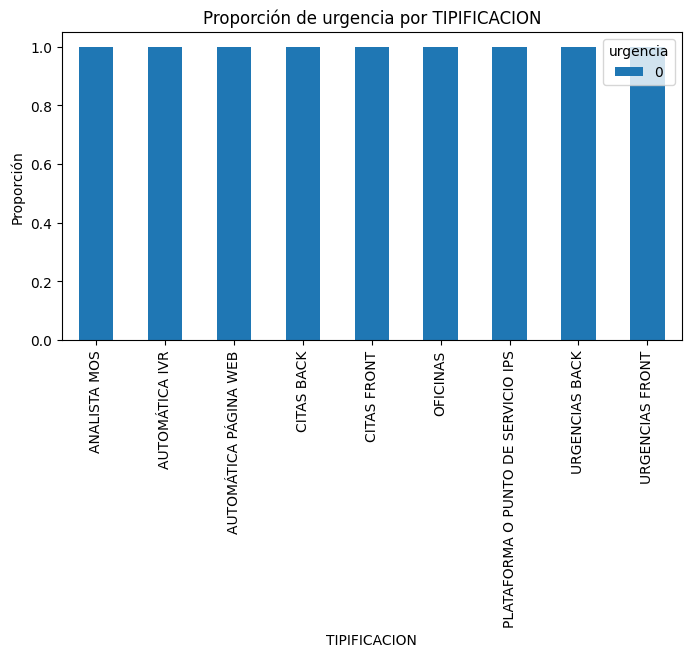


Variable categórica: Concepto_Factura_Desc
urgencia                                     0
Concepto_Factura_Desc                         
ACUPUNTURA (L)                             325
ANAL CLIN REQUERIMIENTOPUESTO TRABAJO(L)  1262
ANALISIS DE PUESTO DE TRABAJO PSICOSOCIA     3
ANGIOGRAFIA OCULAR (L)                      20
ANÁLISIS CLÍNICO DEL CASO- REINCORPO (L)  1427
...                                        ...
VACUNACION TETANOS (L)                     133
VAL INTERDISCIPL INICIAL REHAB INTEG(L)    298
VAL INTERDISCIPLIN INCLUSIÓN SOCIOLAB(L)     2
VAL POR FISIATRÍA INCUMPLIM OBJETIV(L)      87
ÓRTESIS LINEA BLANDA SILLAS DE RUEDAS(L)    58

[355 rows x 1 columns]
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


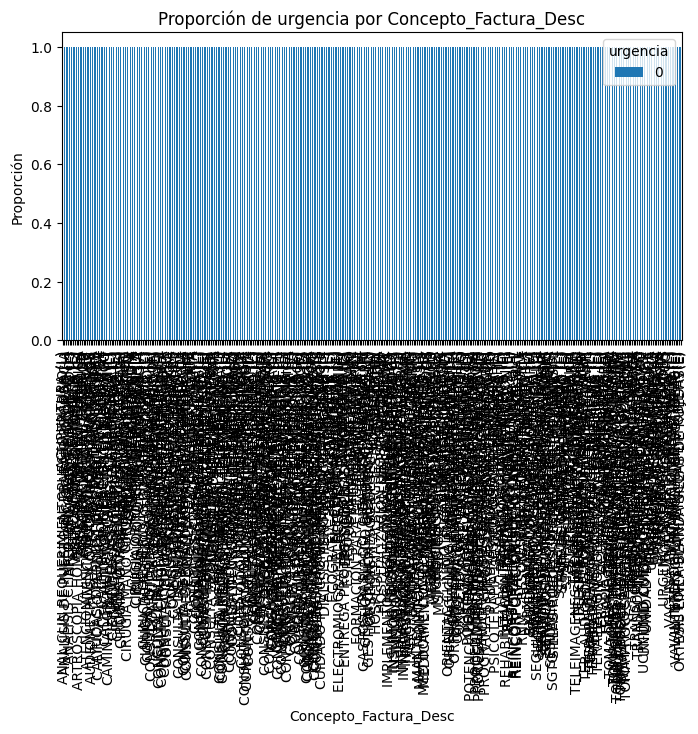


Variable categórica: MUNICIPIO
urgencia                   0
MUNICIPIO                   
ABEJORRAL                340
ABREGO                    53
ABRIAQUI                  49
ACACIAS                 1130
ACANDI                   146
...                      ...
ZARAGOZA                 701
ZARZAL-VALLE DEL CAUCA  1760
ZETAQUIRA                  5
ZIPACON                   48
ZIPAQUIRA               2332

[1076 rows x 1 columns]
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


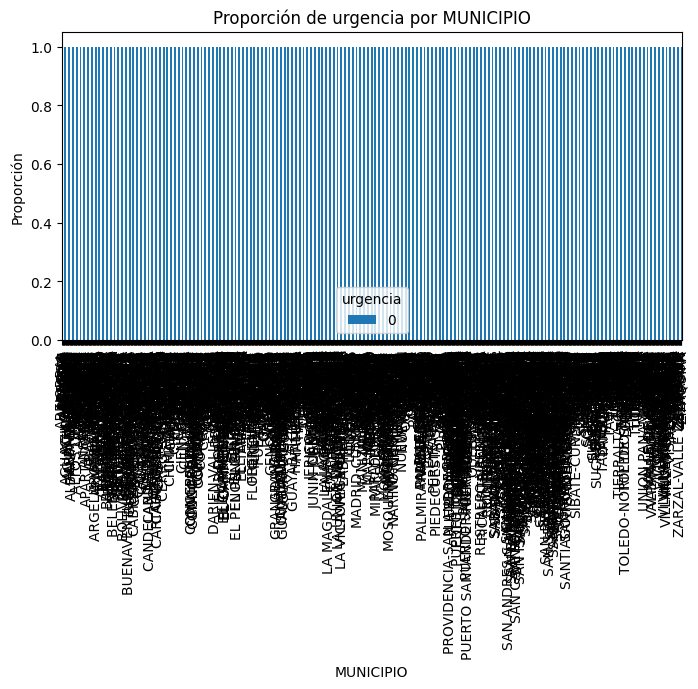


Variable categórica: urgencia
urgencia        0
urgencia         
0         1000000
No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.


In [ ]:
for cat in cat_vars:
    print(f"\nVariable categórica: {cat}")
    # Tabla de contingencia
    contingency = pd.crosstab(muestra_filtrada[cat], muestra_filtrada['urgencia'])
    print(contingency)

    # Prueba de chi-cuadrado (solo si hay más de una categoría en urgencia)
    if contingency.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f"Chi-cuadrado: {chi2:.2f}, p-valor: {p:.4f}")
    else:
        print("No se puede calcular chi-cuadrado: solo hay una categoría en 'urgencia'.")

    # Gráfico de proporciones
    contingency_norm = contingency.div(contingency.sum(1), axis=0)
    contingency_norm.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f'Proporción de urgencia por {cat}')
    plt.ylabel('Proporción')
    plt.show()

En la muetsra grande de df tampoco hay categoria de urgencia

### Preprocesamiento de los datos

In [ ]:
print("Cantidad de registros por municipio:")
print(muestra_filtrada['MUNICIPIO2'].value_counts().head(20))  # Top 20 municipios


Cantidad de registros por municipio:
MUNICIPIO2
BOGOTA                 212901
MEDELLIN               133229
SANTIAGO DE CALI        63355
BARRANQUILLA            45653
CARTAGENA DE INDIAS     25899
BUCARAMANGA             23516
ITAGUI                  16468
CUCUTA                  12477
PEREIRA                 11725
MANIZALES               11697
RIONEGRO                11583
BELLO                   10321
IBAGUE                   9221
ENVIGADO                 9185
PALMIRA                  8194
SANTA MARTA              7889
YUMBO                    7825
SABANETA                 6604
VILLAVICENCIO            6598
LA ESTRELLA              6492
Name: count, dtype: int64


In [ ]:
# Cantidad de registros por departamento
print("\nCantidad de registros por departamento:")
print(muestra_filtrada['Nombre_Departamento_IPS'].value_counts().head(20))  # Top 20 departamentos



Cantidad de registros por departamento:
Nombre_Departamento_IPS
ANTIOQUIA             570041
?                     153670
BOGOTA D.C.            73520
VALLE DEL CAUCA        55076
SANTANDER              25414
ATLANTICO              23156
RISARALDA              13457
CUNDINAMARCA           11987
NORTE DE SANTANDER     10893
META                    9773
HUILA                   7059
BOLIVAR                 6037
TOLIMA                  5373
CALDAS                  4997
CESAR                   4872
CORDOBA                 4317
NARIÑO                  3528
MAGDALENA               3380
BOYACA                  3209
QUINDIO                 2728
Name: count, dtype: int64[pyarrow]


In [ ]:
# Municipios y departamentos únicos
print("\nNúmero de municipios únicos:", muestra_filtrada['MUNICIPIO2'].nunique())
print("Número de departamentos únicos:", muestra_filtrada['Nombre_Departamento_IPS'].nunique())


Número de municipios únicos: 995
Número de departamentos únicos: 32


In [ ]:
print("\nEjemplo de valores en FECHA_PROCESO:")
print(muestra_filtrada['FECHA_PROCESO'].head(10))


Ejemplo de valores en FECHA_PROCESO:
146347    28/06/2019 14:50:35
128711     2/10/2019 16:39:01
136196    21/06/2019 17:59:03
137608    28/08/2019 08:10:34
165027    17/05/2019 16:01:12
31311      1/02/2019 16:36:11
131739    22/01/2019 14:30:17
103256     8/10/2019 17:20:04
2700      24/07/2019 07:06:24
99294      8/04/2019 12:40:44
Name: FECHA_PROCESO, dtype: string


In [ ]:
muestra_filtrada['FECHA_PROCESO_parsed'] = pd.to_datetime(muestra_filtrada['FECHA_PROCESO'], errors='coerce')
print("\nCantidad de fechas no convertidas (NaT):", muestra_filtrada['FECHA_PROCESO_parsed'].isna().sum())


Cantidad de fechas no convertidas (NaT): 0


<ipython-input-74-afd510006903>:1: UserWarning:

Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

<ipython-input-74-afd510006903>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("\nRango de fechas (FECHA_PROCESO):")
print(muestra_filtrada['FECHA_PROCESO_parsed'].min(), "a", muestra_filtrada['FECHA_PROCESO_parsed'].max())


Rango de fechas (FECHA_PROCESO):
2014-10-22 16:43:58 a 2025-01-08 19:05:16


Inspeccion de los meses y años

In [ ]:
print("Valores únicos en 'AÑO':", muestra_filtrada['AÑO'].unique())
print("Frecuencia de valores en 'AÑO':")
print(muestra_filtrada['AÑO'].value_counts().sort_index())

Valores únicos en 'AÑO': [2019. 2020. 2021. 2022. 2023. 2024.]
Frecuencia de valores en 'AÑO':
AÑO
2019.0    137332
2020.0    138000
2021.0    162667
2022.0    175157
2023.0    187124
2024.0    199720
Name: count, dtype: int64


In [ ]:
print("\nValores únicos en 'MES':", muestra_filtrada['MES'].unique())
print("Frecuencia de valores en 'MES':")
print(muestra_filtrada['MES'].value_counts().sort_index())


Valores únicos en 'MES': [ 7 10  8  5  2  4  9  3 11  1 12  6]
Frecuencia de valores en 'MES':
MES
1     80071
2     83106
3     83624
4     73363
5     81520
6     77353
7     85294
8     86072
9     89352
10    90303
11    86704
12    83238
Name: count, dtype: int64


In [ ]:
print("\nCantidad de valores nulos en 'AÑO':", muestra_filtrada['AÑO'].isnull().sum())
print("Cantidad de valores nulos en 'MES':", muestra_filtrada['MES'].isnull().sum())

print("\nTipo de dato de 'AÑO':", muestra_filtrada['AÑO'].dtype)
print("Tipo de dato de 'MES':", muestra_filtrada['MES'].dtype)


Cantidad de valores nulos en 'AÑO': 0
Cantidad de valores nulos en 'MES': 0

Tipo de dato de 'AÑO': float64
Tipo de dato de 'MES': int64


In [ ]:
muestra_filtrada['AÑO_num'] = pd.to_numeric(muestra_filtrada['AÑO'], errors='coerce')
muestra_filtrada['MES_num'] = pd.to_numeric(muestra_filtrada['MES'], errors='coerce')

print("\nValores no convertibles en 'AÑO':", muestra_filtrada['AÑO'].isnull().sum())
print("Valores no convertibles en 'MES':", muestra_filtrada['MES'].isnull().sum())

print("\nRango de años:", muestra_filtrada['AÑO_num'].min(), "a", muestra_filtrada['AÑO_num'].max())
print("Rango de meses:", muestra_filtrada['MES_num'].min(), "a", muestra_filtrada['MES_num'].max())


Valores no convertibles en 'AÑO': 0
Valores no convertibles en 'MES': 0

Rango de años: 2019.0 a 2024.0
Rango de meses: 1 a 12


<ipython-input-84-bd61dd578365>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-bd61dd578365>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



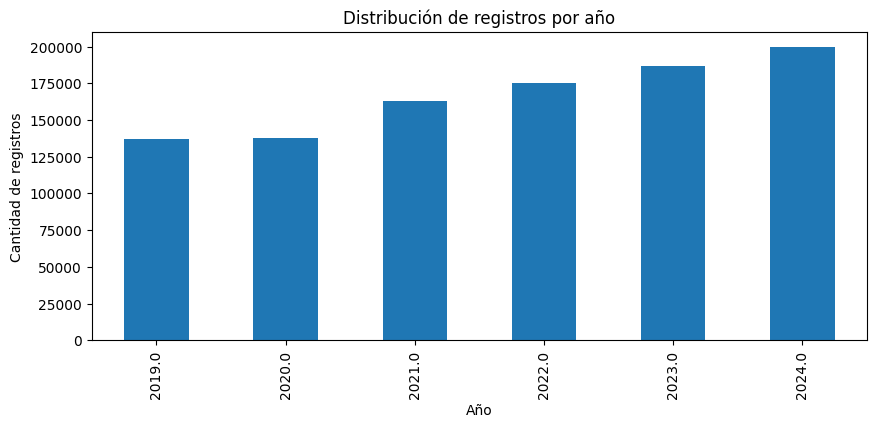

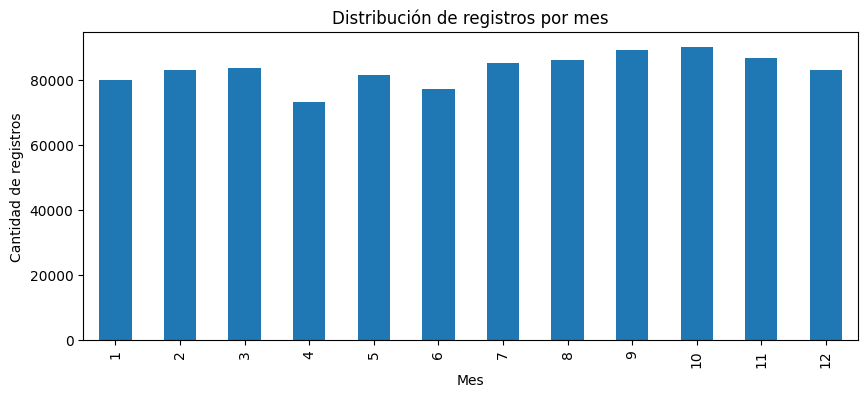

In [ ]:

plt.figure(figsize=(10,4))
muestra_filtrada['AÑO_num'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de registros por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de registros')
plt.show()

plt.figure(figsize=(10,4))
muestra_filtrada['MES_num'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de registros por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de registros')
plt.show()

Observar la distribución o inciio de las fechas

In [ ]:
# Registros con FECHA_PROCESO antes de 2019
antiguos = muestra_filtrada[muestra_filtrada['FECHA_PROCESO_parsed'].dt.year < 2019]
print("Cantidad de registros con FECHA_PROCESO antes de 2019:", len(antiguos))
print("Valores únicos de AÑO en esos registros:", antiguos['AÑO'].unique())

Cantidad de registros con FECHA_PROCESO antes de 2019: 2094
Valores únicos de AÑO en esos registros: [2019. 2020. 2021. 2023. 2024.]


In [ ]:
print("\nPorcentaje de valores nulos por columna:")
print(muestra_filtrada[['Siniestro_Diagnosti_Princi_Id', 'Nombre_Tipo_Atencion_Arp',
                        'Nombre_Municipio_IPS', 'Nombre_Departamento_IPS', 'FECHA_PROCESO',
                        'TIPIFICACION', 'AÑO', 'PERIODO', 'Cantidad', 'MES',
                        'categoria_servicios', 'MUNICIPIO2']].isnull().mean() * 100)


Porcentaje de valores nulos por columna:
Siniestro_Diagnosti_Princi_Id     0.0000
Nombre_Tipo_Atencion_Arp          0.0000
Nombre_Municipio_IPS              0.0000
Nombre_Departamento_IPS           0.0000
FECHA_PROCESO                     0.0000
TIPIFICACION                      0.0000
AÑO                               0.0000
PERIODO                           0.0000
Cantidad                          0.0000
MES                               0.0000
categoria_servicios              25.6235
MUNICIPIO2                        0.0000
dtype: float64


In [ ]:
print("\nTipos de datos:")
print(muestra_filtrada.dtypes)


Tipos de datos:
Numero_Uen_Arp                         string[pyarrow]
Siniestro_Arp_Id                       string[pyarrow]
Nombre_Sinies_Diagnosti_Princi         string[pyarrow]
Siniestro_Diagnosti_Princi_Id          string[pyarrow]
Nombre_Tipo_Atencion_Arp               string[pyarrow]
Nombre_Municipio_IPS                   string[pyarrow]
Nombre_Departamento_IPS                string[pyarrow]
NOMBRE_MUNICIPIO_SUCURSAL              string[pyarrow]
NOMBRE_DEPARTAMENTO_SUCURSAL           string[pyarrow]
Nombre_Municipio_Establecimiento       string[pyarrow]
Nombre_Departamento_Establecimiento    string[pyarrow]
FECHA_PROCESO                          string[pyarrow]
FECHA_ATENCION                         string[pyarrow]
DSTIPO_EXAMEN                          string[pyarrow]
FECHA_FIN_INCAPACIDAD                  string[pyarrow]
FECHA_INICIO_INCAPACIDAD               string[pyarrow]
TIPIFICACION                           string[pyarrow]
Concepto_Factura_Desc                  string[py

In [ ]:
print("\nEstadísticas de 'Cantidad':")
print(muestra_filtrada['Cantidad'].describe())


Estadísticas de 'Cantidad':
count    1000000.000000
mean           1.326748
std            1.586119
min            1.000000
25%            1.000000
50%            1.000000
75%            1.000000
max           90.000000
Name: Cantidad, dtype: float64


In [ ]:
print("\nValores negativos en 'Cantidad':", (muestra_filtrada['Cantidad'] < 0).sum())


Valores negativos en 'Cantidad': 0


Observar interrogantes

In [ ]:
cat_vars = [
    'Numero_Uen_Arp', 'Siniestro_Arp_Id', 'Nombre_Sinies_Diagnosti_Princi',
    'Siniestro_Diagnosti_Princi_Id', 'Nombre_Tipo_Atencion_Arp',
    'Nombre_Municipio_IPS', 'Nombre_Departamento_IPS', 'NOMBRE_MUNICIPIO_SUCURSAL',
    'NOMBRE_DEPARTAMENTO_SUCURSAL', 'Nombre_Municipio_Establecimiento',
    'Nombre_Departamento_Establecimiento', 'FECHA_PROCESO', 'FECHA_ATENCION',
    'DSTIPO_EXAMEN', 'FECHA_FIN_INCAPACIDAD', 'FECHA_INICIO_INCAPACIDAD',
    'TIPIFICACION', 'Concepto_Factura_Desc', 'PERIODO', 'MUNICIPIO',
    'AÑO_PER', 'categoria_servicios', 'tipo_categoria', 'descripcion_tipo_categoria',
    'MUNICIPIO2'
]

In [ ]:
tabla_resumen = []

for var in cat_vars:
    total = muestra_filtrada[var].shape[0]
    count_q = (muestra_filtrada[var] == '?').sum()
    percent_q = 100 * count_q / total
    n_categorias = muestra_filtrada[var].nunique()
    categoria_mas_frecuente = muestra_filtrada[var].value_counts().idxmax()
    freq_mas_frecuente = muestra_filtrada[var].value_counts().max()
    tabla_resumen.append({
        'Variable': var,
        'Registros con "?"': count_q,
        '% con "?"': round(percent_q, 2),
        'Total categorías': n_categorias,
        'Categoría más frecuente': categoria_mas_frecuente,
        'Frecuencia más frecuente': freq_mas_frecuente
    })



In [ ]:
df_resumen = pd.DataFrame(tabla_resumen)
df_resumen

Variable  Registros con "?"  % con "?"  \
0                        Numero_Uen_Arp                  0       0.00   
1                      Siniestro_Arp_Id                  0       0.00   
2        Nombre_Sinies_Diagnosti_Princi                  0       0.00   
3         Siniestro_Diagnosti_Princi_Id                  0       0.00   
4              Nombre_Tipo_Atencion_Arp                  0       0.00   
5                  Nombre_Municipio_IPS             153670      15.37   
6               Nombre_Departamento_IPS             153670      15.37   
7             NOMBRE_MUNICIPIO_SUCURSAL             272110      27.21   
8          NOMBRE_DEPARTAMENTO_SUCURSAL             272110      27.21   
9      Nombre_Municipio_Establecimiento             769093      76.91   
10  Nombre_Departamento_Establecimiento             769093      76.91   
11                        FECHA_PROCESO                  0       0.00   
12                       FECHA_ATENCION                  0       0.00   
13                        DSTIPO_EXAMEN             799942      79.99   
14                FECHA_FIN_INCAPACIDAD             925506      92.55   
15             FECHA_INICIO_INCAPACIDAD             925506      92.55   
16                         TIPIFICACION                  0       0.00   
17                Concepto_Factura_Desc                  0       0.00   
18                              PERIODO                  0       0.00   
19                            MUNICIPIO                  0       0.00   
20                              AÑO_PER                  0       0.00   
21                  categoria_servicios                  0       0.00   
22                       tipo_categoria                  0       0.00   
23           descripcion_tipo_categoria                  0       0.00   
24                           MUNICIPIO2                  0       0.00   

    Total categorías      Categoría más frecuente  Frecuencia más frecuente  
0                 49                          219                     87309  
1             473521                   a9693b6d92                       144  
2                898                         G560                     48026  
3                898                         G560                     48026  
4                  7                  AMBULATORIA                    530160  
5                372                     MEDELLIN                    547909  
6                 32                    ANTIOQUIA                    570041  
7                507                            ?                    272110  
8                 32                            ?                    272110  
9                189                            ?                    769093  
10                28                            ?                    769093  
11            989895          31/10/2022 11:58:33                       158  
12            574160          2024-10-30 12:00:00                       297  
13               183                            ?                    799942  
14              2243                            ?                    925506  
15              2212                            ?                    925506  
16                 9              URGENCIAS FRONT                    313881  
17               355    MEDICAMENTOS AMBULATORIOS                    141619  
18                72                      2024-07                     18303  
19              1076                       BOGOTA                    212901  
20                 6                         2024                    199720  
21               206  2 MEDICAMENTOS AMBULATORIOS                    141619  
22                 2                            2                    690839  
23                 2      Incidentes no laborales                    690839  
24               995                       BOGOTA                    212901

#### Variable objetivo

In [74]:
muestra_filtrada['Cantidad'].value_counts()

Cantidad
1.0     894954
2.0      75893
10.0     20515
5.0       4041
20.0       910
8.0        818
15.0       686
6.0        643
7.0        562
4.0        311
3.0        209
30.0       121
9.0        106
12.0        88
40.0        29
24.0        25
14.0        10
11.0        10
25.0         9
36.0         9
16.0         8
60.0         7
13.0         6
48.0         5
18.0         5
21.0         5
19.0         3
45.0         3
90.0         2
50.0         1
72.0         1
26.0         1
28.0         1
85.0         1
31.0         1
32.0         1
Name: count, dtype: int64

Modificar la variable objetivo a una clasificación a través de rangos de demanda

In [84]:
def categorizar_cantidad(x):
    if x <= 2:
        return 'baja'
    elif x <= 10:
        return 'media'
    else:
        return 'alta'

muestra_filtrada['Cantidad_cat'] = muestra_filtrada['Cantidad'].apply(categorizar_cantidad)

<ipython-input-84-7e745f0bdb0f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra_filtrada['Cantidad_cat'] = muestra_filtrada['Cantidad'].apply(categorizar_cantidad)


In [85]:
muestra_filtrada['Cantidad_cat'].value_counts()

Cantidad_cat
baja     970847
media     27205
alta       1948
Name: count, dtype: int64

In [ ]:
muestra_filtrada.head()

Numero_Uen_Arp Siniestro_Arp_Id Nombre_Sinies_Diagnosti_Princi  \
146347            214       efac8678e7                           S934   
128711            211       d314190ee0                           T313   
136196            511       82184846dc                           S028   
137608            313       23bffa0e25                           S626   
165027            417       c3a9d9d035                           S609   

       Siniestro_Diagnosti_Princi_Id       Nombre_Tipo_Atencion_Arp  \
146347                          S934                    AMBULATORIA   
128711                          T313  UNIDAD DE CUIDADOS INTENSIVOS   
136196                          S028  UNIDAD DE CUIDADOS INTENSIVOS   
137608                          S626        QUIRURGICO HOSPITALARIO   
165027                          S609                    AMBULATORIA   

       Nombre_Municipio_IPS Nombre_Departamento_IPS NOMBRE_MUNICIPIO_SUCURSAL  \
146347             MEDELLIN               ANTIOQUIA                  MEDELLIN   
128711             MEDELLIN               ANTIOQUIA                  MEDELLIN   
136196             MEDELLIN               ANTIOQUIA                VALLEDUPAR   
137608              ARMENIA                 QUINDIO                     TULUA   
165027             MEDELLIN               ANTIOQUIA                    BOGOTA   

       NOMBRE_DEPARTAMENTO_SUCURSAL Nombre_Municipio_Establecimiento  ...  \
146347                    ANTIOQUIA                                ?  ...   
128711                    ANTIOQUIA                         MEDELLIN  ...   
136196                        CESAR                                ?  ...   
137608              VALLE DEL CAUCA                                ?  ...   
165027                  BOGOTA D.C.                                ?  ...   

       AÑO_PER MES                 categoria_servicios tipo_categoria  \
146347    2019   7          2 SESIONES DE FISIOTERAPIA              2   
128711    2019  10         2 MEDICAMENTOS AMBULATORIOS              2   
136196    2019   7  2 MSI -MEDICO SEGUIMIENTO INTEGRAL              2   
137608    2019   8                                 NaN            NaN   
165027    2019   5             2 TERAPEUTA OCUPACIONAL              2   

       descripcion_tipo_categoria  MUNICIPIO2 urgencia FECHA_PROCESO_parsed  \
146347    Incidentes no laborales    SABANETA        0  2019-06-28 14:50:35   
128711    Incidentes no laborales     SEGOVIA        0  2019-10-02 16:39:01   
136196    Incidentes no laborales  VALLEDUPAR        0  2019-06-21 17:59:03   
137608                        NaN      ZARZAL        0  2019-08-28 08:10:34   
165027    Incidentes no laborales      BOGOTA        0  2019-05-17 16:01:12   

        AÑO_num MES_num  
146347   2019.0       7  
128711   2019.0      10  
136196   2019.0       7  
137608   2019.0       8  
165027   2019.0       5  

[5 rows x 34 columns]

#### Preprocessmos los datos

In [15]:
# Variables seleccionadas
vars_modelo = [
    'Siniestro_Diagnosti_Princi_Id',
    'Nombre_Tipo_Atencion_Arp',
    'Nombre_Municipio_IPS',
    'TIPIFICACION',
    'categoria_servicios',
    'MUNICIPIO2',
    'AÑO_PER',
    'MES',
    'Cantidad'
]

In [16]:
# Filtrar registros con '?' en variables categóricas
df = muestra_filtrada[vars_modelo].copy()
for var in vars_modelo:
    if var not in ['Cantidad', 'AÑO_PER', 'MES'] and df[var].dtype == 'object':
        df = df[df[var] != '?']

In [17]:
# Convertir AÑO_PER y MES a numérico
df['AÑO_PER'] = pd.to_numeric(df['AÑO_PER'], errors='coerce')
df['MES'] = pd.to_numeric(df['MES'], errors='coerce')

In [18]:
# Crear columna PERIODO tipo 'YYYY-MM'
df['PERIODO'] = df['AÑO_PER'].astype(int).astype(str) + '-' + df['MES'].astype(int).astype(str).str.zfill(2)

In [19]:
cat_vars = [
    'Siniestro_Diagnosti_Princi_Id',
    'Nombre_Tipo_Atencion_Arp',
    'Nombre_Municipio_IPS',
    'TIPIFICACION',
    'categoria_servicios',
    'MUNICIPIO2'
]
for var in cat_vars:
    le = LabelEncoder()
    df[var] = le.fit_transform(df[var].astype(str))

In [20]:
X = df[cat_vars + ['AÑO_PER', 'MES']]
y = df['Cantidad']

In [21]:
# Separar en train, validación y test según el año
X_train = X[df['AÑO_PER'] <= 2022]
y_train = y[df['AÑO_PER'] <= 2022]

X_val = X[df['AÑO_PER'] == 2023]
y_val = y[df['AÑO_PER'] == 2023]

X_test = X[df['AÑO_PER'] == 2024]
y_test = y[df['AÑO_PER'] == 2024]

# Para predicción de 2025
X_pred_2025 = X[df['AÑO_PER'] == 2025]

In [ ]:
df.head()

Siniestro_Diagnosti_Princi_Id  Nombre_Tipo_Atencion_Arp  \
146347                            698                         1   
128711                            805                         6   
136196                            388                         6   
137608                            591                         5   
165027                            579                         1   

        Nombre_Municipio_IPS  TIPIFICACION  categoria_servicios  MUNICIPIO2  \
146347                   192             6                  188         699   
128711                   192             1                  168         815   
136196                   192             4                  171         946   
137608                    31             8                  206         991   
165027                   192             6                  192          94   

        AÑO_PER  MES  Cantidad  PERIODO  
146347     2019    7       2.0  2019-07  
128711     2019   10       1.0  2019-10  
136196     2019    7       1.0  2019-07  
137608     2019    8       1.0  2019-08  
165027     2019    5       1.0  2019-05

## Modelos Benchmark globales

### Modelo De regresion lineal

#### Definición de métricas

In [22]:
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    # Evita división por cero en MAPE
    mape = (abs((y_true - y_pred) / y_true).replace([float('inf'), -float('inf')], 0)).mean() * 100
    r2 = r2_score(y_true, y_pred)
    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'MSE': mse,
        'R2': r2
    }

In [23]:
resultados = []

In [24]:
# Entrenamiento
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
# Predicciones
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

In [26]:
# Métricas
resultados.append({
    'Modelo': 'LinearRegression (Val)',
    **calcular_metricas(y_val, y_val_pred_lr)
})
resultados.append({
    'Modelo': 'LinearRegression (Test)',
    **calcular_metricas(y_test, y_test_pred_lr)
})

### Modelo de Regresión Ridge

In [27]:
alphas = [0.01, 0.1, 1, 10, 100]
mejor_mae = float('inf')
mejor_alpha = None
mejor_modelo = None

In [28]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_val_pred = ridge.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    if mae < mejor_mae:
        mejor_mae = mae
        mejor_alpha = alpha
        mejor_modelo = ridge

In [29]:
# Predicciones finales con el mejor modelo
y_val_pred_ridge = mejor_modelo.predict(X_val)
y_test_pred_ridge = mejor_modelo.predict(X_test)

In [30]:
resultados.append({
    'Modelo': f'Ridge (Val, alpha={mejor_alpha})',
    **calcular_metricas(y_val, y_val_pred_ridge)
})
resultados.append({
    'Modelo': f'Ridge (Test, alpha={mejor_alpha})',
    **calcular_metricas(y_test, y_test_pred_ridge)
})

### Regresión Lasso con alpha de parámetros

In [31]:
alphas = [0.01, 0.1, 1, 10, 100]
mejor_mae = float('inf')
mejor_alpha = None
mejor_modelo = None

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_val_pred = lasso.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    if mae < mejor_mae:
        mejor_mae = mae
        mejor_alpha = alpha
        mejor_modelo = lasso

In [32]:
# Predicciones finales con el mejor modelo
y_val_pred_lasso = mejor_modelo.predict(X_val)
y_test_pred_lasso = mejor_modelo.predict(X_test)

In [33]:
resultados.append({
    'Modelo': f'Lasso (Val, alpha={mejor_alpha})',
    **calcular_metricas(y_val, y_val_pred_lasso)
})
resultados.append({
    'Modelo': f'Lasso (Test, alpha={mejor_alpha})',
    **calcular_metricas(y_test, y_test_pred_lasso)
})

#### Tabla con métricas

In [34]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE       MSE        R2
0    LinearRegression (Val)  0.558634  29.323461  1.676620  2.811054  0.003290
1   LinearRegression (Test)  0.520481  27.043503  1.605044  2.576168 -0.000038
2   Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620  2.811054  0.003290
3  Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044  2.576168 -0.000038
4   Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211  2.806332  0.004964
5  Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712  2.568687  0.002866

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test_pred_lr, alpha=0.3, label='LinearRegression')
plt.scatter(y_test, y_test_pred_ridge, alpha=0.3, label='Ridge')
plt.scatter(y_test, y_test_pred_lasso, alpha=0.3, label='Lasso')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Comparación de predicciones (Test 2024)')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



### Modelo Random Forest para predicción de demanda global

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

In [37]:
# Entrenamiento
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [38]:
# Predicciones
y_val_pred_rf = rf.predict(X_val)
y_test_pred_rf = rf.predict(X_test)

In [39]:
resultados.append({
    'Modelo': 'RandomForest (Val, n=200, d=20, s=5)',
    **calcular_metricas(y_val, y_val_pred_rf)
})
resultados.append({
    'Modelo': 'RandomForest (Test, n=200, d=20, s=5)',
    **calcular_metricas(y_test, y_test_pred_rf)
})

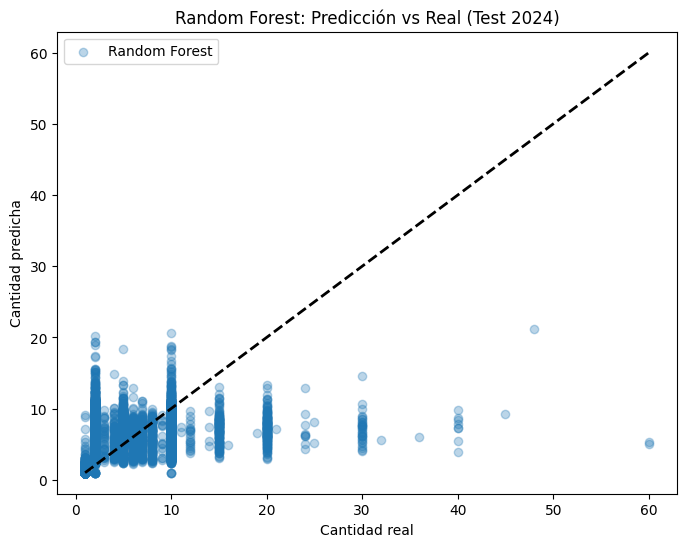

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('Random Forest: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()

In [40]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                 LinearRegression (Val)  0.558634  29.323461  1.676620   
1                LinearRegression (Test)  0.520481  27.043503  1.605044   
2                Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3               Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5               Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6   RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7  RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   

        MSE        R2  
0  2.811054  0.003290  
1  2.576168 -0.000038  
2  2.811054  0.003290  
3  2.576168 -0.000038  
4  2.806332  0.004964  
5  2.568687  0.002866  
6  2.536279  0.100717  
7  2.920410 -0.133668

### Modelo XGBoost

In [41]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [43]:
# Entrenamiento
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [44]:
# Predicciones
y_val_pred_xgb = xgb.predict(X_val)
y_test_pred_xgb = xgb.predict(X_test)

In [45]:
# Agregar métricas a la tabla de resultados
resultados.append({
    'Modelo': 'XGBoost (Val, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_val, y_val_pred_xgb)
})
resultados.append({
    'Modelo': 'XGBoost (Test, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_test, y_test_pred_xgb)
})

In [46]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                 LinearRegression (Val)  0.558634  29.323461  1.676620   
1                LinearRegression (Test)  0.520481  27.043503  1.605044   
2                Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3               Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5               Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6   RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7  RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   
8      XGBoost (Val, n=200, d=8, lr=0.1)  0.395979  16.591407  1.473947   
9     XGBoost (Test, n=200, d=8, lr=0.1)  0.497549  21.843841  1.598193   

        MSE        R2  
0  2.811054  0.003290  
1  2.576168 -0.000038  
2  2.811054  0.003290  
3  2.576168 -0.000038  
4  2.806332  0.004964  
5  2.568687  0.002866  
6  2.536279  0.100717  
7  2.920410 -0.133668  
8  2.172520  0.229694  
9  2.554222  0.008481

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.3, label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('XGBoost: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()

### Modleo LigthGBM

In [47]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.2 MB/s eta 0:00:00


In [48]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [49]:
# Entrenamiento
lgbm.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 613156, number of used features: 8
[LightGBM] [Info] Start training from score 1.315812


LGBMRegressor(colsample_bytree=0.8, max_depth=8, n_estimators=200, n_jobs=-1,
              random_state=42, subsample=0.8)

In [50]:
# Predicciones
y_val_pred_lgbm = lgbm.predict(X_val)
y_test_pred_lgbm = lgbm.predict(X_test)



In [51]:
resultados.append({
    'Modelo': 'LightGBM (Val, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_val, y_val_pred_lgbm)
})
resultados.append({
    'Modelo': 'LightGBM (Test, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_test, y_test_pred_lgbm)
})

In [52]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                  LinearRegression (Val)  0.558634  29.323461  1.676620   
1                 LinearRegression (Test)  0.520481  27.043503  1.605044   
2                 Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3                Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                 Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5                Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6    RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7   RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   
8       XGBoost (Val, n=200, d=8, lr=0.1)  0.395979  16.591407  1.473947   
9      XGBoost (Test, n=200, d=8, lr=0.1)  0.497549  21.843841  1.598193   
10     LightGBM (Val, n=200, d=8, lr=0.1)  0.366889  14.626384  1.395025   
11    LightGBM (Test, n=200, d=8, lr=0.1)  0.468676  19.875931  1.528181   

         MSE        R2  
0   2.811054  0.003290  
1   2.576168 -0.000038  
2   2.811054  0.003290  
3   2.576168 -0.000038  
4   2.806332  0.004964  
5   2.568687  0.002866  
6   2.536279  0.100717  
7   2.920410 -0.133668  
8   2.172520  0.229694  
9   2.554222  0.008481  
10  1.946095  0.309977  
11  2.335337  0.093450

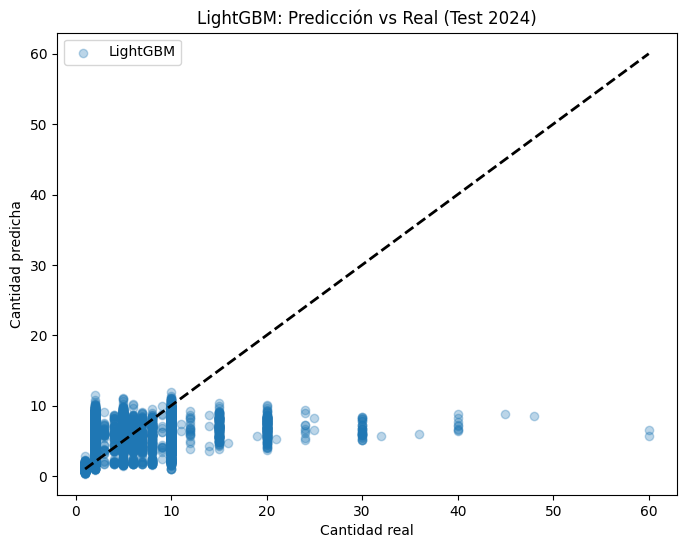

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lgbm, alpha=0.3, label='LightGBM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('LightGBM: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()

### Modelo Catboost

In [53]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.1 MB/s eta 0:00:00


In [54]:
from catboost import CatBoostRegressor

# Configuración recomendada para un primer benchmark
catb = CatBoostRegressor(
    iterations=200,        # Número de árboles
    depth=8,               # Profundidad moderada
    learning_rate=0.1,     # Tasa de aprendizaje estándar
    subsample=0.8,         # Submuestreo para evitar overfitting
    random_seed=42,
    verbose=0              # No mostrar el output de entrenamiento
)

In [55]:
# Entrenamiento
catb.fit(X_train, y_train)

In [56]:
# Predicciones
y_val_pred_catb = catb.predict(X_val)
y_test_pred_catb = catb.predict(X_test)

In [57]:
# Agregar métricas a la tabla de resultados
resultados.append({
    'Modelo': 'CatBoost (Val, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_val, y_val_pred_catb)
})
resultados.append({
    'Modelo': 'CatBoost (Test, n=200, d=8, lr=0.1)',
    **calcular_metricas(y_test, y_test_pred_catb)
})

In [58]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                  LinearRegression (Val)  0.558634  29.323461  1.676620   
1                 LinearRegression (Test)  0.520481  27.043503  1.605044   
2                 Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3                Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                 Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5                Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6    RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7   RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   
8       XGBoost (Val, n=200, d=8, lr=0.1)  0.395979  16.591407  1.473947   
9      XGBoost (Test, n=200, d=8, lr=0.1)  0.497549  21.843841  1.598193   
10     LightGBM (Val, n=200, d=8, lr=0.1)  0.366889  14.626384  1.395025   
11    LightGBM (Test, n=200, d=8, lr=0.1)  0.468676  19.875931  1.528181   
12     CatBoost (Val, n=200, d=8, lr=0.1)  0.377635  14.892505  1.453740   
13    CatBoost (Test, n=200, d=8, lr=0.1)  0.490704  20.740959  1.609423   

         MSE        R2  
0   2.811054  0.003290  
1   2.576168 -0.000038  
2   2.811054  0.003290  
3   2.576168 -0.000038  
4   2.806332  0.004964  
5   2.568687  0.002866  
6   2.536279  0.100717  
7   2.920410 -0.133668  
8   2.172520  0.229694  
9   2.554222  0.008481  
10  1.946095  0.309977  
11  2.335337  0.093450  
12  2.113360  0.250670  
13  2.590242 -0.005501

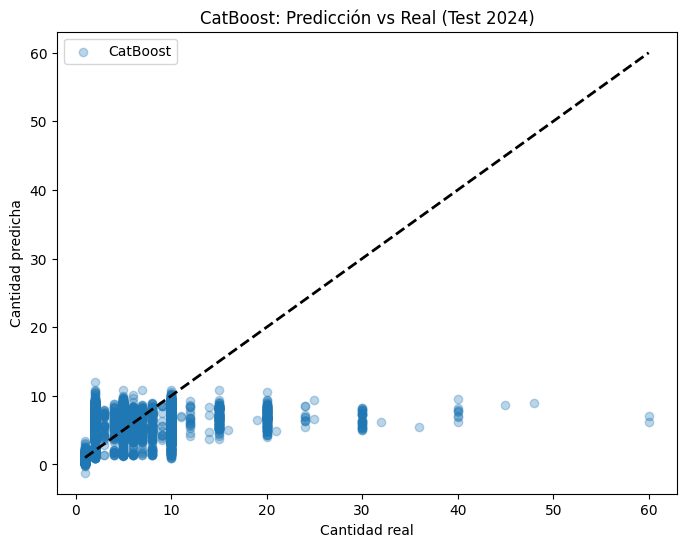

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_catb, alpha=0.3, label='CatBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('CatBoost: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()

### Modelos de predicción para conteos

#### Modelo Poisson para conteo

In [60]:
!pip install statsmodels

In [61]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Unimos X y y para statsmodels
df_train = X_train.copy()
df_train['Cantidad'] = y_train

df_val = X_val.copy()
df_val['Cantidad'] = y_val

df_test = X_test.copy()
df_test['Cantidad'] = y_test

In [62]:
# Lista de variables predictoras
predictoras = list(X_train.columns)
formula = 'Cantidad ~ ' + ' + '.join(predictoras)

In [63]:
# Ajustar el modelo Poisson
poisson_model = smf.glm(formula=formula, data=df_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Cantidad   No. Observations:               613156
Model:                            GLM   Df Residuals:                   613147
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6018e+05
Date:                Tue, 22 Apr 2025   Deviance:                   4.3017e+05
Time:                        21:57:39   Pearson chi2:                 1.02e+06
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02872
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [64]:
# Predicciones
y_val_pred_pois = poisson_model.predict(df_val)
y_test_pred_pois = poisson_model.predict(df_test)

In [65]:
resultados.append({
    'Modelo': 'Poisson (Val)',
    **calcular_metricas(y_val, y_val_pred_pois)
})
resultados.append({
    'Modelo': 'Poisson (Test)',
    **calcular_metricas(y_test, y_test_pred_pois)
})



In [66]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                  LinearRegression (Val)  0.558634  29.323461  1.676620   
1                 LinearRegression (Test)  0.520481  27.043503  1.605044   
2                 Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3                Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                 Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5                Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6    RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7   RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   
8       XGBoost (Val, n=200, d=8, lr=0.1)  0.395979  16.591407  1.473947   
9      XGBoost (Test, n=200, d=8, lr=0.1)  0.497549  21.843841  1.598193   
10     LightGBM (Val, n=200, d=8, lr=0.1)  0.366889  14.626384  1.395025   
11    LightGBM (Test, n=200, d=8, lr=0.1)  0.468676  19.875931  1.528181   
12     CatBoost (Val, n=200, d=8, lr=0.1)  0.377635  14.892505  1.453740   
13    CatBoost (Test, n=200, d=8, lr=0.1)  0.490704  20.740959  1.609423   
14                          Poisson (Val)  0.554853  28.937042  1.676524   
15                         Poisson (Test)  0.516515  26.639770  1.604673   

         MSE        R2  
0   2.811054  0.003290  
1   2.576168 -0.000038  
2   2.811054  0.003290  
3   2.576168 -0.000038  
4   2.806332  0.004964  
5   2.568687  0.002866  
6   2.536279  0.100717  
7   2.920410 -0.133668  
8   2.172520  0.229694  
9   2.554222  0.008481  
10  1.946095  0.309977  
11  2.335337  0.093450  
12  2.113360  0.250670  
13  2.590242 -0.005501  
14  2.810733  0.003404  
15  2.574974  0.000426

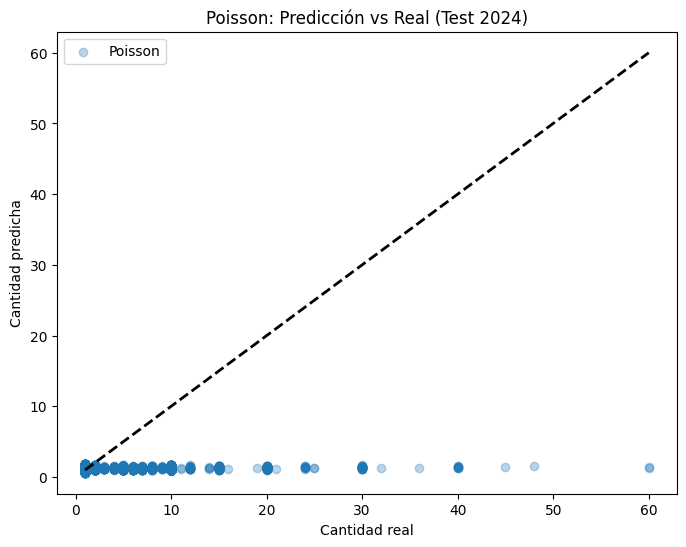

In [67]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_pois, alpha=0.3, label='Poisson')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('Poisson: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()

#### Binomial Negativa

In [68]:
# Ajustar el modelo Binomial Negativa
nb_model = smf.glm(formula=formula, data=df_train, family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Cantidad   No. Observations:               613156
Model:                            GLM   Df Residuals:                   613147
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.6714e+05
Date:                Tue, 22 Apr 2025   Deviance:                   1.2135e+05
Time:                        22:00:15   Pearson chi2:                 4.22e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01249
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [69]:
# Predicciones
y_val_pred_nb = nb_model.predict(df_val)
y_test_pred_nb = nb_model.predict(df_test)

In [70]:
resultados.append({
    'Modelo': 'NegBinomial (Val)',
    **calcular_metricas(y_val, y_val_pred_nb)
})
resultados.append({
    'Modelo': 'NegBinomial (Test)',
    **calcular_metricas(y_test, y_test_pred_nb)
})



In [71]:
df_resultados = pd.DataFrame(resultados)
df_resultados

Modelo       MAE       MAPE      RMSE  \
0                  LinearRegression (Val)  0.558634  29.323461  1.676620   
1                 LinearRegression (Test)  0.520481  27.043503  1.605044   
2                 Ridge (Val, alpha=0.01)  0.558634  29.323461  1.676620   
3                Ridge (Test, alpha=0.01)  0.520481  27.043503  1.605044   
4                 Lasso (Val, alpha=0.01)  0.572460  30.827605  1.675211   
5                Lasso (Test, alpha=0.01)  0.538705  29.054095  1.602712   
6    RandomForest (Val, n=200, d=20, s=5)  0.393677  15.456851  1.592570   
7   RandomForest (Test, n=200, d=20, s=5)  0.495953  20.869491  1.708921   
8       XGBoost (Val, n=200, d=8, lr=0.1)  0.395979  16.591407  1.473947   
9      XGBoost (Test, n=200, d=8, lr=0.1)  0.497549  21.843841  1.598193   
10     LightGBM (Val, n=200, d=8, lr=0.1)  0.366889  14.626384  1.395025   
11    LightGBM (Test, n=200, d=8, lr=0.1)  0.468676  19.875931  1.528181   
12     CatBoost (Val, n=200, d=8, lr=0.1)  0.377635  14.892505  1.453740   
13    CatBoost (Test, n=200, d=8, lr=0.1)  0.490704  20.740959  1.609423   
14                          Poisson (Val)  0.554853  28.937042  1.676524   
15                         Poisson (Test)  0.516515  26.639770  1.604673   
16                      NegBinomial (Val)  0.557287  29.197116  1.675967   
17                     NegBinomial (Test)  0.519523  26.976702  1.603813   

         MSE        R2  
0   2.811054  0.003290  
1   2.576168 -0.000038  
2   2.811054  0.003290  
3   2.576168 -0.000038  
4   2.806332  0.004964  
5   2.568687  0.002866  
6   2.536279  0.100717  
7   2.920410 -0.133668  
8   2.172520  0.229694  
9   2.554222  0.008481  
10  1.946095  0.309977  
11  2.335337  0.093450  
12  2.113360  0.250670  
13  2.590242 -0.005501  
14  2.810733  0.003404  
15  2.574974  0.000426  
16  2.808865  0.004067  
17  2.572216  0.001496

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_nb, alpha=0.3, label='NegBinomial')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Cantidad real')
plt.ylabel('Cantidad predicha')
plt.title('NegBinomial: Predicción vs Real (Test 2024)')
plt.legend()
plt.show()